# Project Title: *Evaluating Mildly Conservative Q-Learning for Offline Reinforcement Learning in Grid-World Navigation*

  ## Introduction:
  This project investigates the application of Mildly Conservative Q-Learning (MCQL), an offline reinforcement learning algorithm, in a grid-world navigation task. A dataset of 4,000 A* trajectories was used to train and evaluate a behavior policy modeled with a Conditional Variational Autoencoder (CVAE), achieving only 44% accuracy. Despite low training losses, the target policy trained with MCQL was unable to guide the robot to the goal, highlighting challenges in aligning offline RL training with task-specific performance.







# Uploading map files:
To set up the grid-world environment, we need to upload the map files (map.pgm and map.yaml) that define the occupancy grid and metadata for the environment. These files are used to create the simulation space for the agent.

The following code allows you to upload the required files directly to the Google Colab environment. Once uploaded, these files will be saved locally in the Colab runtime for further processing.
##Instructions:

* Click on the "Choose Files" button in the output cell.
* Select both map.pgm and map.yaml files from your local machine.
* Once the upload is complete, you can proceed to parse and visualize the map in the next steps.

In [2]:
from google.colab import files

uploaded_files = files.upload()  # Upload map


Saving sim_classroom_map_enhanced.pgm to sim_classroom_map_enhanced.pgm
Saving sim_classroom_map_enhanced.yaml to sim_classroom_map_enhanced.yaml


# 1.1 Visualize Original Map
##Visualize for reference (Optional)

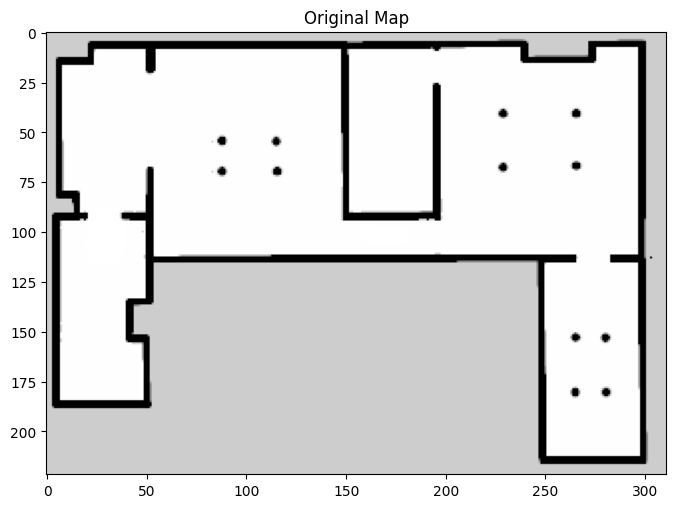

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and display the map
map_image = Image.open('sim_classroom_map_enhanced.pgm')
plt.figure(figsize=(8, 8))
plt.imshow(map_image, cmap='gray')
plt.title('Original Map')
plt.show()


# Map Loading and Parsing
The following code defines a Map class to handle the loading and parsing of the grid-world environment from the provided map files (map.pgm and map.yaml). This includes:

##Loading Metadata:

The .yaml file contains metadata about the map, such as resolution, origin, and file references.
The metadata is parsed using the yaml library and converted into a structured DataFrame using pandas.
Processing the Map Image:

The .pgm file is the occupancy grid, representing the environment as an image.
The map image is loaded using the PIL library and converted into a grayscale numpy array for numerical processing.
Key Components:

##Usage:

The Map object is initialized with the map name (e.g., map), automatically loading the associated files (map.yaml and map.pgm).
`













In [3]:
import numpy as np
# Load the map image
map_image = Image.open('sim_classroom_map_enhanced.pgm').convert("L")
map_array = np.array(map_image)

# Define thresholds for occupancy grid classification
occupied_threshold = 50   # Black (obstacles)
free_threshold = 240      # White (free space)

# Create occupancy grid
occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # Default to unknown (-1)
occupancy_grid[map_array >= free_threshold] = 0  # Free space
occupancy_grid[map_array <= occupied_threshold] = 1  # Obstacles


##Visualize 2D Occupancy Grid (Optional)



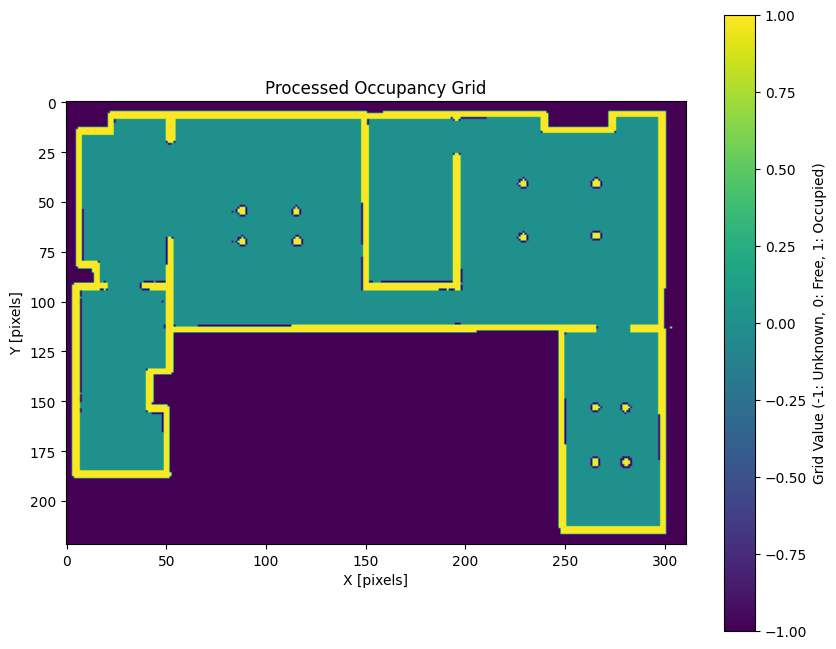

In [4]:
plt.figure(figsize=(10, 8))
plt.title("Processed Occupancy Grid")
plt.imshow(occupancy_grid, cmap='viridis', origin='upper')  # Set origin to 'upper' for consistent alignment
plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")
plt.xlabel("X [pixels]")
plt.ylabel("Y [pixels]")
plt.show()

#1.4 Inflate Obstacles and Sample Start and Goal Points.
##  Inflate obstacles using a dilation kernel to account for robot dimensions.
## Sample start and goal points within free space, ensuring that the start and goal points are sampled at least 0.1m from occupied cells,

Start Point: (126, 272)
Fixed Goal Point: (93, 72)


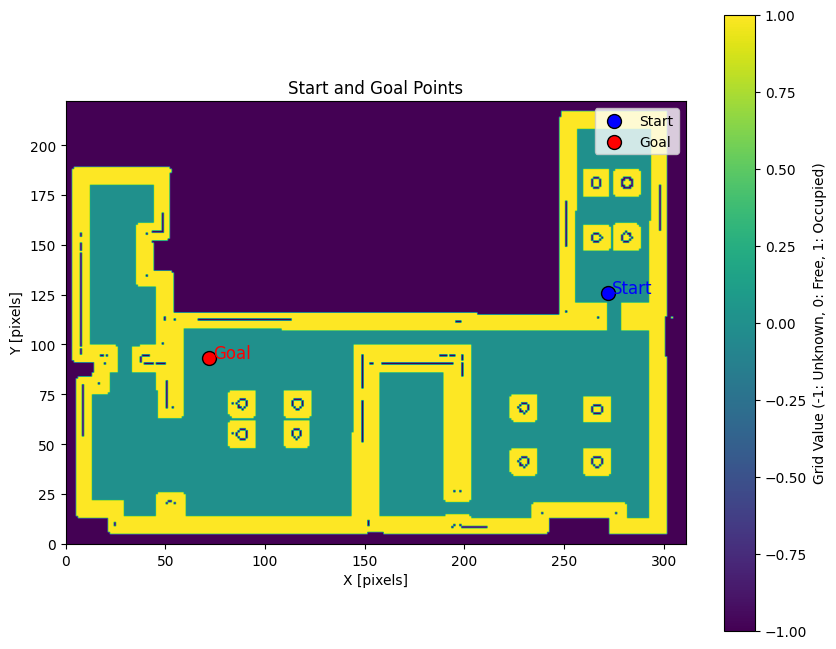

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Step 1: Map Processing Function
def process_map(image_path, occupied_threshold=50, free_threshold=240):
    """
    Process a grayscale map image into an occupancy grid.

    Parameters:
    - image_path: Path to the image file.
    - occupied_threshold: Pixel value below this is considered occupied.
    - free_threshold: Pixel value above this is considered free.

    Returns:
    - Occupancy grid (numpy array): -1 for unknown, 0 for free, 1 for occupied.
    """
    map_image = Image.open(image_path).convert("L")  # Load as grayscale
    map_array = np.array(map_image)

    # Initialize occupancy grid
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # Default to unknown (-1)
    occupancy_grid[map_array >= free_threshold] = 0  # Free space
    occupancy_grid[map_array <= occupied_threshold] = 1  # Occupied

    return occupancy_grid

# Step 2: Sample Free Space (for Start Points)
def sample_free_space(grid, num_points=1, min_distance_m=0.2, resolution_m=0.05):
    """
    Sample random points within the free space (grid cells with value 0), ensuring they are
    at least a specified distance from occupied cells.

    Parameters:
    - grid: The occupancy grid (values: 0 for free, 1 for occupied, -1 for unknown).
    - num_points: Number of points to sample.
    - min_distance_m: Minimum distance from occupied cells (in meters).
    - resolution_m: Resolution of the grid (meters per pixel).

    Returns:
    - List of (x, y) coordinates for sampled points.
    """
    # Compute the minimum distance in pixels
    min_distance_pixels = int(min_distance_m / resolution_m)

    # Create a structuring element for dilation based on the minimum distance
    struct = np.ones((2 * min_distance_pixels + 1, 2 * min_distance_pixels + 1), dtype=bool)

    # Dilate occupied cells to create a "restricted zone"
    restricted_zone = binary_dilation(grid == 1, structure=struct)

    # Identify valid free cells (free space that is not in the restricted zone)
    valid_free_cells = np.argwhere((grid == 0) & ~restricted_zone)

    if len(valid_free_cells) < num_points:
        raise ValueError(f"Not enough valid free space to sample {num_points} points with the given constraints.")

    # Randomly sample indices from valid free cells
    sampled_indices = np.random.choice(len(valid_free_cells), size=num_points, replace=False)
    sampled_points = [tuple(valid_free_cells[idx]) for idx in sampled_indices]

    return sampled_points

# Step 3: Obstacle Inflation Function
def inflate_obstacles(grid, inflation_radius_pixels):
    """
    Inflate obstacles in a 2D occupancy grid.

    Parameters:
    - grid: The occupancy grid (values: 0 for free, 1 for occupied, -1 for unknown).
    - inflation_radius_pixels: Inflation radius in pixels.

    Returns:
    - Inflated occupancy grid.
    """
    # Create a structuring element for inflation
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)

    # Identify occupied cells
    occupied_mask = (grid == 1)

    # Perform binary dilation to inflate obstacles
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)

    # Create a new grid for the inflated result
    inflated_grid = np.copy(grid)

    # Update free cells (0) within the inflated region to occupied (1)
    inflated_grid[inflated_occupied & (grid == 0)] = 1  # Ensure free cells are updated

    # Ensure unknown cells remain untouched
    inflated_grid[grid == -1] = -1  # Preserve unknown cells

    return inflated_grid

# Step 4: Visualization Function
def visualize_start_goal(grid, start, goal, title="Start and Goal Points"):
    """
    Visualize the occupancy grid with start and goal points.

    Parameters:
    - grid: The occupancy grid (values: 0 for free, 1 for occupied, -1 for unknown).
    - start: Tuple (x, y) for the start point.
    - goal: Tuple (x, y) for the goal point.
    - title: Title for the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(grid, cmap='viridis', origin='lower', extent=[0, grid.shape[1], 0, grid.shape[0]])
    plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")

    # Plot start and goal points
    plt.scatter(start[1], start[0], color='blue', label='Start', s=100, edgecolors='black')
    plt.scatter(goal[1], goal[0], color='red', label='Goal', s=100, edgecolors='black')

    # Annotate the start and goal points
    plt.text(start[1] + 2, start[0], "Start", color='blue', fontsize=12)
    plt.text(goal[1] + 2, goal[0], "Goal", color='red', fontsize=12)

    # Add labels, title, and legend
    plt.xlabel("X [pixels]")
    plt.ylabel("Y [pixels]")
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(False)
    plt.show()

# Step 5: Main Workflow
# Upload the map file to Colab and update the path
image_path = "/content/sim_classroom_map_enhanced.pgm"  # Ensure this matches your uploaded file's path

# Process the map to create an occupancy grid
original_grid = process_map(image_path)

# Inflate obstacles
inflation_radius = 5  # Number of pixels to inflate
inflated_grid = inflate_obstacles(original_grid, inflation_radius_pixels=inflation_radius)

# Fix the goal
goal_point = (93, 72)  # Fixed goal coordinate

# Sample random start points
start_point = sample_free_space(inflated_grid, num_points=1)[0]
print("Start Point:", start_point)
print("Fixed Goal Point:", goal_point)

# Visualize the inflated grid with start and fixed goal points
visualize_start_goal(inflated_grid, start_point, goal_point)


## **Step 1: Map Processing**
**Function**: `process_map(image_path, occupied_threshold=50, free_threshold=240)`  
**Purpose**: Converts a grayscale image (e.g., a map) into a numerical occupancy grid:
- **Unknown cells (-1)**: Pixels between `occupied_threshold` and `free_threshold`.
- **Free space (0)**: Pixels above `free_threshold`.
- **Occupied space (1)**: Pixels below `occupied_threshold`.

**Key Parameters**:
- `image_path`: Path to the map image file.
- `occupied_threshold` and `free_threshold`: Define free and occupied pixel ranges.

**Output**: A 2D `numpy` array representing the occupancy grid.

---

## **Step 2: Sampling Free Space**
**Function**: `sample_free_space(grid, num_points=1, min_distance_m=0.2, resolution_m=0.05)`  
**Purpose**: Selects valid start points in the free space (value `0`) of the occupancy grid.

**Key Features**:
- Ensures points are at least `min_distance_m` from obstacles using binary dilation.
- Samples a specified number of random start points.

**Key Parameters**:
- `grid`: Input occupancy grid.
- `min_distance_m`: Minimum distance (in meters) from obstacles.
- `resolution_m`: Resolution of the grid (meters per pixel).

**Output**: A list of `(x, y)` coordinates for start points.

---

## **Step 3: Obstacle Inflation**
**Function**: `inflate_obstacles(grid, inflation_radius_pixels)`  
**Purpose**: Expands (inflates) obstacles to account for robot size and safety margins.

**Key Features**:
- Uses binary dilation to expand obstacles by `inflation_radius_pixels`.
- Keeps unknown cells (`-1`) unchanged.

**Key Parameters**:
- `grid`: Input occupancy grid.
- `inflation_radius_pixels`: Radius of inflation (in pixels).

**Output**: A new grid with inflated obstacles.

---

## **Step 4: Visualization**
**Function**: `visualize_start_goal(grid, start, goal, title="Start and Goal Points")`  
**Purpose**: Displays the occupancy grid and overlays start and goal points.

**Key Features**:
- Color-coded heatmap of the grid.
- Marks start (blue) and goal (red) points.
- Includes a legend and title.

**Parameters**:
- `grid`: The occupancy grid.
- `start` and `goal`: Coordinates of start and goal points.
- `title`: Title of the


In [ ]:
import os
import json
import numpy as np
from scipy.ndimage import binary_dilation
from PIL import Image
from tqdm import tqdm
import heapq
import random

# -------------------------------
# Step 1: A* Algorithm Implementation
# -------------------------------

def astar(grid, start, goal):
    """
    Perform A* search to find a path from start to goal on the grid.

    Args:
        grid (np.ndarray): 2D array where 0 represents free space and 1 represents obstacles.
        start (tuple): Starting coordinates (x, y).
        goal (tuple): Goal coordinates (x, y).

    Returns:
        list: List of coordinates from start to goal, including both.
              Returns empty list if no path is found.
    """
    # Define the possible movements: up, left, down, right
    movements = [(-1, 0), (0, -1), (1, 0), (0, 1)]
    movement_actions = {(-1, 0): 0, (0, -1): 1, (1, 0): 2, (0, 1): 3}  # Mapping to actions

    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start, None))  # (f_score, g_score, current, parent)
    came_from = {}
    g_score = {start: 0}

    closed_set = set()

    while open_set:
        current_f, current_g, current, parent = heapq.heappop(open_set)

        if current in closed_set:
            continue

        came_from[current] = parent

        if current == goal:
            # Reconstruct path
            path = []
            while current is not None:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        closed_set.add(current)

        for move in movements:
            neighbor = (current[0] + move[0], current[1] + move[1])

            # Check boundaries
            if (0 <= neighbor[0] < grid.shape[0]) and (0 <= neighbor[1] < grid.shape[1]):
                if grid[neighbor] == 1:
                    continue  # Obstacle

                tentative_g_score = current_g + 1  # Assuming cost=1 for each move

                if neighbor in g_score and tentative_g_score >= g_score[neighbor]:
                    continue  # Not a better path

                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score, tentative_g_score, neighbor, current))

    return []  # No path found

def heuristic(a, b):
    """
    Heuristic function for A* (Manhattan distance).

    Args:
        a (tuple): Coordinates of point a.
        b (tuple): Coordinates of point b.

    Returns:
        int: Manhattan distance between a and b.
    """
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# -------------------------------
# Step 2: Helper Functions
# -------------------------------

def process_map(image_path, occupied_threshold=50, free_threshold=240):
    """
    Process the map image into an occupancy grid.

    Args:
        image_path (str): Path to the map image.
        occupied_threshold (int): Pixel value below which is considered occupied.
        free_threshold (int): Pixel value above which is considered free.

    Returns:
        np.ndarray: Processed occupancy grid.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Map image not found at {image_path}.")
    map_image = Image.open(image_path).convert("L")
    map_array = np.array(map_image)
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # -1: Unknown
    occupancy_grid[map_array >= free_threshold] = 0           # 0: Free
    occupancy_grid[map_array <= occupied_threshold] = 1       # 1: Occupied
    print(f"Map processed: {occupancy_grid.shape[0]} rows, {occupancy_grid.shape[1]} columns.")
    return occupancy_grid

def inflate_obstacles(grid, inflation_radius_pixels):
    """
    Inflate obstacles in the occupancy grid to account for robot's size.

    Args:
        grid (np.ndarray): Original occupancy grid.
        inflation_radius_pixels (int): Number of pixels to inflate.

    Returns:
        np.ndarray: Inflated occupancy grid.
    """
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)
    occupied_mask = (grid == 1)
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)
    inflated_grid = np.copy(grid)
    inflated_grid[inflated_occupied & (grid == 0)] = 1  # Inflate free spaces to occupied
    print(f"Obstacles inflated by {inflation_radius_pixels} pixels.")
    return inflated_grid

def get_free_cells(grid):
    """
    Get a list of free cells in the grid.

    Args:
        grid (np.ndarray): Occupancy grid.

    Returns:
        list: List of free cell coordinates [(x1, y1), (x2, y2), ...]
    """
    free = np.argwhere(grid == 0)
    free_cells = [tuple(cell) for cell in free]
    print(f"Total free cells: {len(free_cells)}")
    return free_cells

def sample_start_goal(free_cells, num_samples):
    """
    Randomly sample start and goal positions from free cells.

    Args:
        free_cells (list): List of free cell coordinates.
        num_samples (int): Number of start-goal pairs to sample.

    Returns:
        list: List of (start, goal) tuples.
    """
    sampled_pairs = []
    num_free = len(free_cells)
    attempts = 0
    max_attempts = num_samples * 10  # To prevent infinite loop

    while len(sampled_pairs) < num_samples and attempts < max_attempts:
        start = random.choice(free_cells)
        goal = random.choice(free_cells)
        if start != goal:
            sampled_pairs.append((start, goal))
        attempts += 1

    if len(sampled_pairs) < num_samples:
        print(f"Warning: Only {len(sampled_pairs)} unique start-goal pairs were sampled.")
    else:
        print(f"Sampled {len(sampled_pairs)} start-goal pairs.")
    return sampled_pairs

def get_action(current, next_):
    """
    Determine the action taken to move from current to next.

    Args:
        current (tuple): Current coordinates (x, y).
        next_ (tuple): Next coordinates (x, y).

    Returns:
        int: Action index (0: Up, 1: Left, 2: Down, 3: Right)
    """
    dx = next_[0] - current[0]
    dy = next_[1] - current[1]
    if dx == -1 and dy == 0:
        return 0  # Up
    elif dx == 0 and dy == -1:
        return 1  # Left
    elif dx == 1 and dy == 0:
        return 2  # Down
    elif dx == 0 and dy == 1:
        return 3  # Right
    else:
        return -1  # Invalid action

# -------------------------------
# Step 3: Main Function to Generate Dataset
# -------------------------------

def generate_a_star_dataset(map_path, output_path, inflation_radius=5, num_paths=10000):
    """
    Generate A* trajectories and save as a dataset.

    Args:
        map_path (str): Path to the .pgm map image.
        output_path (str): Path to save the JSON dataset.
        inflation_radius (int): Number of pixels to inflate obstacles.
        num_paths (int): Number of trajectories to generate.

    Returns:
        None
    """
    # Process the map
    occupancy_grid = process_map(map_path)
    inflated_grid = inflate_obstacles(occupancy_grid, inflation_radius)
    free_cells = get_free_cells(inflated_grid)

    # Sample start and goal positions
    sampled_pairs = sample_start_goal(free_cells, num_paths)

    # Initialize dataset list
    dataset = []

    # Generate paths
    print("\n--- Generating A* Paths ---")
    for idx, (start, goal) in enumerate(tqdm(sampled_pairs, desc="Generating Paths")):
        path = astar(inflated_grid, start, goal)
        if not path:
            # No path found; skip this pair
            continue
        # Iterate through the path to create transitions
        for i in range(len(path) - 1):
            current_state = path[i]
            next_state = path[i + 1]
            action = get_action(current_state, next_state)
            if action == -1:
                # Invalid action; skip
                continue
            transition = {
                "s": list(current_state),
                "a": action,
                "r": -1,  # Step penalty
                "s_prime": list(next_state),
                "d": False
            }
            dataset.append(transition)
        # Last step
        transition = {
            "s": list(path[-2]),
            "a": get_action(path[-2], path[-1]),
            "r": 100,  # Reward for reaching goal
            "s_prime": list(path[-1]),
            "d": True
        }
        dataset.append(transition)

    print(f"\nTotal transitions generated: {len(dataset)}")

    # Save the dataset as JSON
    with open(output_path, "w") as f:
        json.dump(dataset, f)

    print(f"Dataset saved at {output_path}.")

# -------------------------------
# Step 4: Execute the Dataset Generation
# -------------------------------

if __name__ == "__main__":
    # Define paths
    map_path = "sim_classroom_map_enhanced.pgm"  # Update with your map path
    output_path = "rl_dataset3.json"            # Output dataset path
    inflation_radius = 5                        # Pixels to inflate obstacles
    num_paths = 10000                            # Number of trajectories

    # Check if map exists
    if not os.path.exists(map_path):
        print(f"Map file not found at {map_path}. Please provide the correct path.")
    else:
        # Generate the dataset
        generate_a_star_dataset(map_path, output_path, inflation_radius, num_paths)


In [23]:
# -------------------------------
# Step 1: Import Libraries
# -------------------------------

import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
from scipy.ndimage import binary_dilation
from tqdm import tqdm

# -------------------------------
# Step 2: Define the Policy Network
# -------------------------------

# Define the Behavior Policy Model
class BehaviorPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, num_layers=3):
        super(BehaviorPolicy, self).__init__()
        layers = []
        input_dim = state_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, action_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, state):
        return self.model(state)

# -------------------------------
# Step 3: Define the RL Dataset Class
# -------------------------------

class RLDataset(Dataset):
    def __init__(self, data):
        """
        Initialize the dataset with states, actions, rewards, next_states, and done flags.

        Args:
            data (list): List of data entries, each being a dictionary with keys 's', 'a', 'r', 's\'', 'd'.
        """
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)
        self.rewards = torch.tensor([entry['r'] for entry in data], dtype=torch.float32)
        self.next_states = torch.tensor([entry["s'"] for entry in data], dtype=torch.float32)
        self.dones = torch.tensor([entry['d'] for entry in data], dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[idx]

# -------------------------------
# Step 4: Define Helper Functions
# -------------------------------

def process_map(image_path, occupied_threshold=50, free_threshold=240):
    """
    Process the map image into an occupancy grid.

    Args:
        image_path (str): Path to the map image.
        occupied_threshold (int): Pixel value below which is considered occupied.
        free_threshold (int): Pixel value above which is considered free.

    Returns:
        np.ndarray: Processed occupancy grid.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Map image not found at {image_path}.")
    map_image = Image.open(image_path).convert("L")
    map_array = np.array(map_image)
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # -1: Unknown
    occupancy_grid[map_array >= free_threshold] = 0           # 0: Free
    occupancy_grid[map_array <= occupied_threshold] = 1       # 1: Occupied
    print(f"Map processed: {occupancy_grid.shape[0]} rows, {occupancy_grid.shape[1]} columns.")
    return occupancy_grid

def inflate_obstacles(grid, inflation_radius_pixels):
    """
    Inflate obstacles in the occupancy grid to account for robot's size.

    Args:
        grid (np.ndarray): Original occupancy grid.
        inflation_radius_pixels (int): Number of pixels to inflate.

    Returns:
        np.ndarray: Inflated occupancy grid.
    """
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)
    occupied_mask = (grid == 1)
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)
    inflated_grid = np.copy(grid)
    inflated_grid[inflated_occupied & (grid == 0)] = 1  # Inflate free spaces to occupied
    print(f"Obstacles inflated by {inflation_radius_pixels} pixels.")
    return inflated_grid

def move_in_direction(state, action):
    """
    Map action index to movement direction and compute the next state.

    Args:
        state (tuple): Current state coordinates (x, y).
        action (int): Action index (0: Up, 1: Down, 2: Left, 3: Right).

    Returns:
        tuple: Next state coordinates (x, y).
    """
    # Define action mapping: 0-Up, 1-Down, 2-Left, 3-Right
    directions = {
        0: (-1, 0),  # Up
        1: (1, 0),   # Down
        2: (0, -1),  # Left
        3: (0, 1)    # Right
    }
    if action not in directions:
        raise ValueError(f"Invalid action index: {action}")
    dx, dy = directions[action]
    return (state[0] + dx, state[1] + dy)

def compute_reward(current_state, next_state, goal, done):
    """
    Compute the reward for transitioning from current_state to next_state.

    Args:
        current_state (tuple): Current state coordinates (x, y).
        next_state (tuple): Next state coordinates (x, y).
        goal (tuple): Goal coordinates (x, y).
        done (bool): Whether the episode has terminated.

    Returns:
        float: Calculated reward.
    """
    if next_state == goal:
        return 100  # Large reward for reaching the goal
    else:
        return -1   # Penalty for each step taken

def evaluate_single_trajectory(model, start_state, goal, grid, max_steps=1000, device="cpu"):
    """
    Simulate the policy from a single start state and collect trajectory data.

    Args:
        model (nn.Module): The trained policy network.
        start_state (tuple): Starting state coordinates (x, y).
        goal (tuple): Goal coordinates (x, y).
        grid (np.ndarray): Inflated occupancy grid.
        max_steps (int): Maximum steps per episode.
        device (torch.device): Device to run the model on.

    Returns:
        dict: Trajectory data containing start, goal, path, success, collision, and reward.
    """
    model.eval()
    current_state = start_state
    path = [current_state]
    success = False
    collision = False
    cumulative_reward = 0.0

    for step in range(max_steps):
        state_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(state_tensor)
            action = torch.argmax(logits, dim=1).item()

        next_state = move_in_direction(current_state, action)

        # Ensure next_state coordinates are integers
        next_state = (int(next_state[0]), int(next_state[1]))

        # Check boundaries
        if not (0 <= next_state[0] < grid.shape[0] and 0 <= next_state[1] < grid.shape[1]):
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        # Check collision
        if grid[next_state] == 1:
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        # Compute reward
        done = False
        if next_state == goal:
            success = True
            done = True
        reward = compute_reward(current_state, next_state, goal, done)
        cumulative_reward += reward

        path.append(next_state)
        current_state = next_state

        if done:
            break

    trajectory = {
        "Start": f"({start_state[0]}, {start_state[1]})",
        "Goal": f"({goal[0]}, {goal[1]})",
        "Path": path,
        "Success": "y" if success else "n",
        "Collision": "y" if collision else "n",
        "Reward Received": cumulative_reward
    }

    return trajectory

def visualize_path(grid, path, goal, title="Path Visualization"):
    """
    Visualize the robot's path on the occupancy grid.

    Args:
        grid (np.ndarray): Occupancy grid.
        path (list): List of state tuples representing the path.
        goal (tuple): Goal coordinates (x, y).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray", origin="lower")
    plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")

    # Extract x and y coordinates from path
    x_coords, y_coords = zip(*path)
    plt.plot(y_coords, x_coords, marker='o', color='blue', label="Path")
    plt.scatter(y_coords[0], x_coords[0], color='green', s=100, label="Start", edgecolors="black")
    plt.scatter(goal[1], goal[0], color='red', s=100, label="Goal", edgecolors="black")

    plt.title(title)
    plt.xlabel("Y [pixels]")
    plt.ylabel("X [pixels]")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Step 6: Load Dataset and Process Map
# -------------------------------

# Define file paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
model_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/behavior_policy_tuned.pth"
map_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/sim_classroom_map_enhanced.pgm"
csv_output_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/tuned_behavior_policy_performance.csv"

# Define Goal Coordinates
goal = (93, 72)

# Define Inflation Radius
inflation_radius_pixels = 5

# Load and process the map
print("Processing map...")
occupancy_grid = process_map(map_path)
inflated_grid = inflate_obstacles(occupancy_grid, inflation_radius_pixels)

# Load the dataset
print("Loading dataset...")
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}.")
with open(dataset_path, "r") as f:
    rl_data = json.load(f)
print(f"Dataset loaded with {len(rl_data)} entries.")

# Initialize Dataset
full_dataset = RLDataset(rl_data)

# -------------------------------
# Step 7: Load the Trained Behavior Policy Model
# -------------------------------

# Define model parameters
state_dim = 2       # (x, y)
action_dim = 4      # up, down, left, right

# Initialize the model
behavior_policy = BehaviorPolicy(state_dim, action_dim, hidden_dim=256, num_layers=3)

# Load the trained model state
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Behavior Policy model not found at {model_path}.")
behavior_policy.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
behavior_policy.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
behavior_policy.eval()
print(f"Behavior Policy model loaded from {model_path}.")

# -------------------------------
# Step 8: Sample 100 Random Start Points
# -------------------------------

num_samples = 100
if len(full_dataset) < num_samples:
    print(f"Warning: Requested {num_samples} samples, but dataset has only {len(full_dataset)} samples. Using all samples.")
    sampled_indices = list(range(len(full_dataset)))
else:
    sampled_indices = random.sample(range(len(full_dataset)), num_samples)

sampled_entries = [full_dataset[i] for i in sampled_indices]

# -------------------------------
# Step 9: Evaluate the Behavior Policy
# -------------------------------

# Initialize list to store trajectory data
trajectories = []

# Initialize counters for metrics
success_count = 0
collision_count = 0
total_cumulative_reward = 0.0

# Evaluate each sampled start point
print("Evaluating Behavior Policy on sampled start points...")
for idx, (state, action, reward, next_state, done) in enumerate(tqdm(sampled_entries, desc="Evaluating Trajectories")):
    start_state = tuple(state.numpy().astype(int))  # Ensure integer coordinates
    trajectory = evaluate_single_trajectory(
        model=behavior_policy,
        start_state=start_state,
        goal=goal,
        grid=inflated_grid,
        max_steps=1000,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )

    # Update metrics
    if trajectory["Success"] == "y":
        success_count += 1
    if trajectory["Collision"] == "y":
        collision_count += 1
    total_cumulative_reward += trajectory["Reward Received"]

    # Append trajectory data
    trajectories.append({
        "Start": trajectory["Start"],
        "Goal": trajectory["Goal"],
        "Path": trajectory["Path"],
        "Success": trajectory["Success"],
        "Collision": trajectory["Collision"],
        "Reward Received": trajectory["Reward Received"]
    })

# -------------------------------
# Step 10: Compute and Display Metrics
# -------------------------------

success_rate = (success_count / num_samples) * 100
collision_rate = (collision_count / num_samples) * 100
average_cumulative_reward = total_cumulative_reward / num_samples

print("\nEvaluation Metrics:")
print(f"Success Rate: {success_rate:.2f}% ({success_count}/{num_samples})")
print(f"Collision Rate: {collision_rate:.2f}% ({collision_count}/{num_samples})")
print(f"Average Cumulative Reward: {average_cumulative_reward:.2f}")

# -------------------------------
# Step 11: Save Trajectory Data to CSV
# -------------------------------

# Convert trajectories to DataFrame
df_trajectories = pd.DataFrame(trajectories)

# Convert Path from list of tuples to string for CSV
df_trajectories['Path'] = df_trajectories['Path'].apply(lambda x: str(x))

# Save to CSV
df_trajectories.to_csv(csv_output_path, index=False)
print(f"Trajectory data saved to {csv_output_path}.")

# -------------------------------
# Step 12: Generate Meaningful Plots
# -------------------------------

# Plot Success vs. Collision
labels = ['Success', 'Collision']
counts = [success_count, collision_count]
plt.figure(figsize=(6,6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title("Evaluation Results")
plt.ylabel("Number of Episodes")
plt.show()

# Plot Distribution of Cumulative Rewards
plt.figure(figsize=(8,6))
plt.hist(df_trajectories['Reward Received'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Cumulative Rewards")
plt.xlabel("Cumulative Reward")
plt.ylabel("Number of Episodes")
plt.grid(True)
plt.show()

# -------------------------------
# Step 13: (Optional) Visualize a Few Sample Trajectories
# -------------------------------

# Visualize first 5 trajectories
for i in range(min(5, len(df_trajectories))):
    traj = df_trajectories.iloc[i]
    path = eval(traj['Path'])  # Convert string back to list of tuples
    visualize_path(
        grid=inflated_grid,
        path=path,
        goal=goal,
        title=f"Trajectory {i+1}: Start {traj['Start']} - Success: {traj['Success']} - Collision: {traj['Collision']} - Reward: {traj['Reward Received']:.2f}"
    )


Generated 1000/10000 trajectories.
Generated 2000/10000 trajectories.
Generated 3000/10000 trajectories.
Generated 4000/10000 trajectories.
Generated 5000/10000 trajectories.
Generated 6000/10000 trajectories.
Generated 7000/10000 trajectories.
Generated 8000/10000 trajectories.
Generated 9000/10000 trajectories.
Generated 10000/10000 trajectories.
RL dataset saved to /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3.json


## Fitting a Behavior Policy using Behavior CLoning
This script implements a reinforcement learning pipeline to train and evaluate a behavior policy using Optuna for hyperparameter tuning. The pipeline includes dataset preparation, model training, hyperparameter optimization, and evaluation on a Gazebo-based map.

---

## **Step 1: Import Libraries**
- Essential libraries include:
  - `torch` for deep learning.
  - `optuna` for hyperparameter tuning.
  - `matplotlib` for visualizations.
  - `PIL` for image processing.

---

## **Step 2: Setup Logging**
- Configures logging to display informational messages during the script execution.

---

## **Step 3: Define the Behavior Policy Model**
- A fully connected neural network with customizable hidden layers and activation functions.
- Designed to map states to action probabilities.

---

## **Step 4: Define the RL Dataset**
- `RLDataset` class stores and provides access to states and actions for training.
- Supports PyTorch's `DataLoader` for efficient batch processing.

---

## **Step 5: Training Function**
- `train_behavior_policy`: Trains the policy model on the dataset using the specified optimizer and loss function.

---

## **Step 6: Optuna Hyperparameter Tuning**
- **Objective Function**:
  - Evaluates different hyperparameter configurations on the validation loss.
  - Searches over `hidden_dim`, `num_layers`, and `learning_rate`.
- **Visualization**:
  - Generates plots for optimization history and parameter importance.

---

## **Step 7: Dataset Preparation**
- Loads a JSON dataset of state-action pairs.
- Splits the dataset into training (80%) and validation (20%) subsets.

---

## **Step 8: Hyperparameter Tuning**
- Executes Optuna trials to find the best model configuration.
- Outputs the best parameters and validation loss.

---

## **Step 9: Retraining with Best Parameters**
- Retrains the behavior policy model using the best hyperparameters identified by Optuna.
- Tracks training loss across epochs and visualizes it.

---

## **Step 10: Save the Trained Model**
- Saves the trained model weights to a specified file path for future use.

---

## **Step 11: Generate Plots**
- Visualizes the action distribution predicted by the trained model.
- Plots the distribution of actions across the dataset.

---

## **Step 12: Evaluate the Trained Policy**
- Evaluates the policy's success rate on randomly sampled states.
- Simulates trajectories from start states to the goal, measuring success and failure rates.
- Visualizes paths for individual trajectories on the occupancy grid.

---

## **Key Outputs**
- **Hyperparameter Optimization**:
  - Best parameters and validation loss.
- **Training Results**:
  - Training loss over epochs.
- **Evaluation Metrics**:
  - Success rate and trajectory paths.
- **Visualizations**:
  - Action distribution, Optuna plots, and trajectory visualizations.

This modular pipeline ensures easy extension for future tasks like fine-tuning or testing policies in dynamic environments.


[I 2024-12-08 14:03:28,432] A new study created in memory with name: BehaviorPolicyTuning


Dataset split into 1253545 training samples and 313387 validation samples.
Starting hyperparameter tuning with Optuna...


<ipython-input-23-3cc51e82a550>:126: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
[I 2024-12-08 14:09:50,255] Trial 0 finished with value: 0.29567631680806705 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0009994573057805012}. Best is trial 0 with value: 0.29567631680806705.
[I 2024-12-08 14:17:01,933] Trial 1 finished with value: 0.23151462217642624 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'learning_rate': 0.0002440829742081353}. Best is trial 1 with value: 0.23151462217642624.
[I 2024-12-08 14:25:01,165] Trial 2 finished with value: 0.12633900774392925 and parameters: {'hidden_dim': 64, 'num_layers': 3, 'learning_rate': 0.0006782473173656165}. Best is trial 2 with value: 0.12633900774392925.
[I 2024-12-08 14:33:01,933] 

Hyperparameter tuning completed.
Best trial:
  Value (Validation Loss): 0.0991
  Params:


Retraining Behavior Policy with best hyperparameters...
Epoch 1/50, Loss: 0.5766
Epoch 2/50, Loss: 0.3125
Epoch 3/50, Loss: 0.2274
Epoch 4/50, Loss: 0.1966
Epoch 5/50, Loss: 0.1756
Epoch 6/50, Loss: 0.1650
Epoch 7/50, Loss: 0.1550
Epoch 8/50, Loss: 0.1469
Epoch 9/50, Loss: 0.1452
Epoch 10/50, Loss: 0.1375
Epoch 11/50, Loss: 0.1341
Epoch 12/50, Loss: 0.1298
Epoch 13/50, Loss: 0.1272
Epoch 14/50, Loss: 0.1245
Epoch 15/50, Loss: 0.1211
Epoch 16/50, Loss: 0.1181
Epoch 17/50, Loss: 0.1174
Epoch 18/50, Loss: 0.1134
Epoch 19/50, Loss: 0.1119
Epoch 20/50, Loss: 0.1100
Epoch 21/50, Loss: 0.1102
Epoch 22/50, Loss: 0.1070
Epoch 23/50, Loss: 0.1057
Epoch 24/50, Loss: 0.1035
Epoch 25/50, Loss: 0.1021
Epoch 26/50, Loss: 0.1011
Epoch 27/50, Loss: 0.1010
Epoch 28/50, Loss: 0.1002
Epoch 29/50, Loss: 0.0990
Epoch 30/50, Loss: 0.0977
Epoch 31/50, Loss: 0.0973
Epoch 32/50, Loss: 0.0949
Epoch 33/50, Loss: 0.0943
Epoch 34/50, Loss: 0.0937
Epoch 35/50, Loss: 0.0925
Epoch 36/50, Loss: 0.0919
Epoch 37/50, Loss

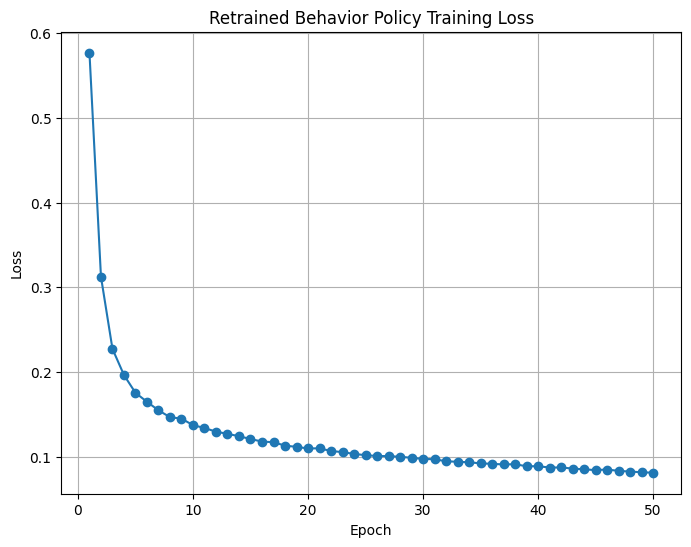

Trained Behavior Policy model saved to /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/behavior_policy_tuned.pth


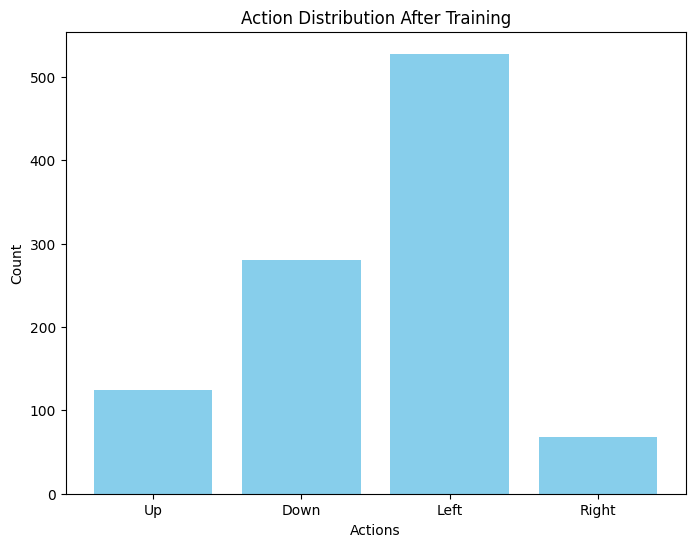

Evaluating the tuned Behavior Policy...


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [23]:


# -------------------------------
# Step 1: Import Libraries
# -------------------------------

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import logging

# -------------------------------
# Step 2: Setup Logging
# -------------------------------

# Configure logging to display informational messages
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# -------------------------------
# Step3: Define the Policy Network
# -------------------------------

# Action mapping (if needed elsewhere)
ACTION_MAP = {
    (-1, 0): 0,  # Up
    (1, 0): 1,   # Down
    (0, -1): 2,  # Left
    (0, 1): 3    # Right
}

# Define the Behavior Policy Model
class BehaviorPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, num_layers=2):
        super(BehaviorPolicy, self).__init__()
        layers = []
        input_dim = state_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, action_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, state):
        return self.model(state)

# -------------------------------
# Step 4: Define the RL Dataset Class
# -------------------------------

class RLDataset(Dataset):
    def __init__(self, data):
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

# -------------------------------
# Step 5: Define Helper Functions
# -------------------------------

def train_behavior_policy(model, dataloader, optimizer, criterion, device, num_epochs=20):
    """
    Train the Behavior Policy model.

    Args:
        model (nn.Module): The policy network.
        dataloader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer.
        criterion (nn.Module): Loss function.
        device (torch.device): Device to train on.
        num_epochs (int): Number of training epochs.

    Returns:
        list: List of average losses per epoch.
    """
    model.to(device)
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for states, actions in dataloader:
            states, actions = states.to(device), actions.to(device)
            optimizer.zero_grad()
            logits = model(states)
            loss = criterion(logits, actions)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return loss_history

def objective(trial, train_dataset, val_dataset, state_dim, action_dim, device):
    """
    Objective function for Optuna hyperparameter tuning.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.
        train_dataset (Dataset): Training dataset.
        val_dataset (Dataset): Validation dataset.
        state_dim (int): Dimension of the state space.
        action_dim (int): Number of possible actions.
        device (torch.device): Device to train on.

    Returns:
        float: Validation loss after training.
    """
    # Hyperparameter search space
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    # Initialize model
    model = BehaviorPolicy(state_dim, action_dim, hidden_dim, num_layers)

    # Define optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Training
    num_epochs = 10  # Fewer epochs for faster tuning
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for states, actions in train_loader:
            states, actions = states.to(device), actions.to(device)
            optimizer.zero_grad()
            logits = model(states)
            loss = criterion(logits, actions)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_train_loss = epoch_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for states, actions in val_loader:
            states, actions = states.to(device), actions.to(device)
            logits = model(states)
            loss = criterion(logits, actions)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    return avg_val_loss

def plot_training_loss(loss_history, title="Training Loss"):
    """
    Plot the training loss over epochs.

    Args:
        loss_history (list): List of loss values.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def tune_hyperparameters(train_dataset, val_dataset, state_dim, action_dim, device, n_trials=50):
    """
    Tune hyperparameters using Optuna.

    Args:
        train_dataset (Dataset): Training dataset.
        val_dataset (Dataset): Validation dataset.
        state_dim (int): Dimension of the state space.
        action_dim (int): Number of possible actions.
        device (torch.device): Device to train on.
        n_trials (int): Number of Optuna trials.

    Returns:
        optuna.Study: The completed Optuna study.
    """
    study = optuna.create_study(direction='minimize', study_name='BehaviorPolicyTuning')
    study.optimize(lambda trial: objective(trial, train_dataset, val_dataset, state_dim, action_dim, device), n_trials=n_trials)
    return study

# -------------------------------
# Step 6: Load Dataset and Split into Training and Validation
# -------------------------------

# Load the Dataset
dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
with open(dataset_path, "r") as f:
    rl_data = json.load(f)

# Initialize Dataset
full_dataset = RLDataset(rl_data)

# Split into Training and Validation (80-20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f"Dataset split into {train_size} training samples and {val_size} validation samples.")

# -------------------------------
# Step 7: Define the Optuna Study and Run Hyperparameter Tuning
# -------------------------------

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Run hyperparameter tuning
print("Starting hyperparameter tuning with Optuna...")
study = tune_hyperparameters(train_dataset, val_dataset, state_dim, action_dim, device, n_trials=20)
print("Hyperparameter tuning completed.")

# Display the best hyperparameters
print(f"Best trial:")
trial = study.best_trial

print(f"  Value (Validation Loss): {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    logging.info(f"    {key}: {value}")

# Plot Optuna Optimization History
fig1 = plot_optimization_history(study)
fig1.show()

# Plot Hyperparameter Importances
fig2 = plot_param_importances(study)
fig2.show()

# -------------------------------
# Step 8: Retrain the Behavior Policy with Best Hyperparameters
# -------------------------------

def retrain_with_best_params(study, train_dataset, val_dataset, state_dim, action_dim, device):
    """
    Retrain the Behavior Policy model using the best hyperparameters found by Optuna.

    Args:
        study (optuna.Study): The completed Optuna study.
        train_dataset (Dataset): Training dataset.
        val_dataset (Dataset): Validation dataset.
        state_dim (int): Dimension of the state space.
        action_dim (int): Number of possible actions.
        device (torch.device): Device to train on.

    Returns:
        nn.Module: The trained Behavior Policy model.
        list: Training loss history.
    """
    best_params = study.best_trial.params
    hidden_dim = best_params['hidden_dim']
    num_layers = best_params['num_layers']
    learning_rate = best_params['learning_rate']

    # Initialize the model with best hyperparameters
    model = BehaviorPolicy(state_dim, action_dim, hidden_dim, num_layers).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Train the model
    num_epochs = 50  # You can adjust this as needed
    print("Retraining Behavior Policy with best hyperparameters...")
    loss_history = train_behavior_policy(model, train_loader, optimizer, criterion, device, num_epochs)
    print("Retraining completed.")

    return model, loss_history

# Retrain the model
trained_model, training_loss = retrain_with_best_params(study, train_dataset, val_dataset, state_dim, action_dim, device)

# Plot Training Loss
plot_training_loss(training_loss, title="Retrained Behavior Policy Training Loss")

# -------------------------------
# Step 9: Save the Trained Model
# -------------------------------

# Define the save path
tuned_model_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/behavior_policy_tuned.pth"

# Save the trained model
torch.save(trained_model.state_dict(), tuned_model_path)
print(f"Trained Behavior Policy model saved to {tuned_model_path}")

# -------------------------------
# Step 10: Generate Meaningful Plots
# -------------------------------

# Optuna's plots have already been generated above.
# Additional plots, such as confusion matrix or action distributions, can be added here if desired.

# Example: Action Distribution after Training
def plot_action_distribution(model, dataset, device, num_samples=1000):
    """
    Plot the distribution of actions predicted by the model.

    Args:
        model (nn.Module): The trained policy network.
        dataset (Dataset): The dataset to sample from.
        device (torch.device): Device to run on.
        num_samples (int): Number of samples to evaluate.
    """
    model.eval()
    actions = []
    sampled_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    sampled_entries = [dataset[i] for i in sampled_indices]

    with torch.no_grad():
        for state, _ in sampled_entries:
            state = state.to(device).unsqueeze(0)
            logits = model(state)
            action = torch.argmax(logits, dim=1).item()
            actions.append(action)

    action_counts = np.bincount(actions, minlength=action_dim)
    plt.figure(figsize=(8,6))
    plt.bar(['Up', 'Down', 'Left', 'Right'], action_counts, color='skyblue')
    plt.title("Action Distribution After Training")
    plt.xlabel("Actions")
    plt.ylabel("Count")
    plt.show()

# Plot Action Distribution
plot_action_distribution(trained_model, full_dataset, device, num_samples=1000)

# -------------------------------
# Step 11: Evaluation of the Trained Behavior Policy
# -------------------------------

def evaluate_policy(model, dataset, grid, goal, device, num_samples=100, max_steps=1000):
    """
    Evaluate the trained policy by measuring the success rate.

    Args:
        model (nn.Module): The trained policy network.
        dataset (Dataset): The full dataset.
        grid (np.ndarray): The inflated occupancy grid.
        goal (tuple): Goal coordinates (x, y).
        device (torch.device): Device to run evaluation on.
        num_samples (int): Number of random states to evaluate.
        max_steps (int): Maximum steps per episode.

    Returns:
        float: Success rate as a percentage.
    """
    model.eval()
    success_count = 0
    sampled_indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    sampled_entries = [dataset[i] for i in sampled_indices]

    for i, (state, action) in enumerate(sampled_entries):
        state = tuple(state.numpy())
        success, path = evaluate_single_state(model, state, goal, grid, max_steps, device)
        if success:
            success_count += 1
        # Visualize the path
        visualize_path(grid, path, goal, title=f"Path for State {state}")

    success_rate = (success_count / len(sampled_entries)) * 100
    print(f"\nPolicy Success Rate: {success_rate:.2f}% ({success_count}/{len(sampled_entries)})")
    return success_rate

# Evaluate the policy
print("Evaluating the tuned Behavior Policy...")
success_rate = evaluate_policy(trained_model, full_dataset, inflated_grid, goal, device, num_samples=100, max_steps=1000)


# Behavior Policy Evaluation

This script implements an evaluation pipeline for a pre-trained behavior policy in a Gazebo-based environment using reinforcement learning techniques. The main tasks include map processing, policy evaluation, and results visualization.

---

## **Step 1: Import Libraries**
- Libraries include `torch`, `numpy`, `matplotlib`, and `PIL` for RL, data manipulation, and visualization.
- Additional utilities like `binary_dilation` (scipy) for obstacle inflation and `tqdm` for progress tracking.

---

## **Step 2: Define the Behavior Policy**
- A neural network (`BehaviorPolicy`) for predicting actions based on state input.
- Configurable with hidden layers and activation functions.

---

## **Step 3: Define the RL Dataset**
- `RLDataset` handles state (`s`), action (`a`), reward (`r`), next state (`s'`), and done (`d`) flags.
- Allows efficient data loading and sampling for training and evaluation.

---

## **Step 4: Helper Functions**
- **Map Processing (`process_map`)**: Converts grayscale maps into occupancy grids.
- **Obstacle Inflation (`inflate_obstacles`)**: Expands obstacles to account for robot dimensions.
- **Movement (`move_in_direction`)**: Maps actions to directional moves.
- **Reward Calculation (`compute_reward`)**: Provides +100 for goal reach and -1 for steps.
- **Trajectory Evaluation (`evaluate_single_trajectory`)**: Simulates the policy and collects performance metrics.
- **Visualization (`visualize_path`)**: Plots paths on the occupancy grid.

---

## **Step 5: Load and Process the Map**
- Converts a `.pgm` map to an occupancy grid.
- Inflates obstacles using a defined pixel radius.

---

## **Step 6: Load Dataset**
- Loads RL data from a JSON file.
- Initializes a dataset object for easy sampling.

---

## **Step 7: Load the Trained Behavior Policy**
- Defines and initializes the policy network.
- Loads the trained model weights from a file.

---

## **Step 8: Sample Start Points**
- Randomly samples valid start points from the dataset for evaluation.

---

## **Step 9: Policy Evaluation**
- Evaluates the behavior policy over sampled start points.
- Tracks metrics such as success, collision, and cumulative rewards.

---

## **Step 10: Compute Metrics**
- Calculates success rate, collision rate, and average cumulative reward.

---

## **Step 11: Save Results**
- Saves trajectory data, including paths, success, and reward, to a CSV file.

---

## **Step 12: Visualize Results**
- Plots success vs. collision counts.
- Displays cumulative reward distribution.

---

## **Step 13: Visualize Sample Trajectories**
- Visualizes individual trajectories on the inflated grid.



Processing map...
Map processed: 222 rows, 311 columns.
Obstacles inflated by 5 pixels.
Loading dataset...
Dataset loaded with 1566932 entries.


<ipython-input-14-058d7f8bd131>:291: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  behavior_policy.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if

Behavior Policy model loaded from /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/behavior_policy_tuned.pth.
Evaluating Behavior Policy on sampled start points...


Evaluating Trajectories: 100%|██████████| 100/100 [00:03<00:00, 30.76it/s]



Evaluation Metrics:
Success Rate: 94.00% (94/100)
Collision Rate: 6.00% (6/100)
Average Cumulative Reward: -5.52
Trajectory data saved to /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/tuned_behavior_policy_performance.csv.


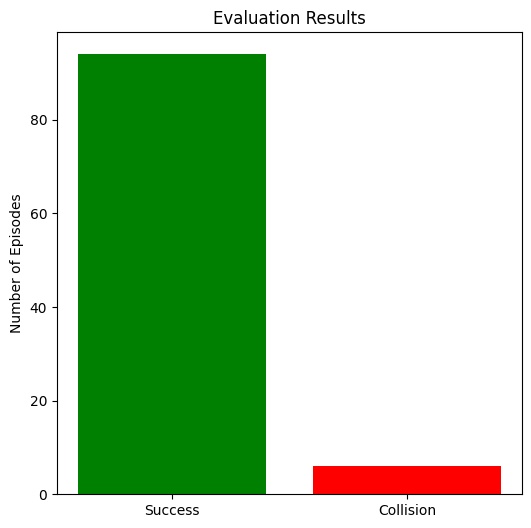

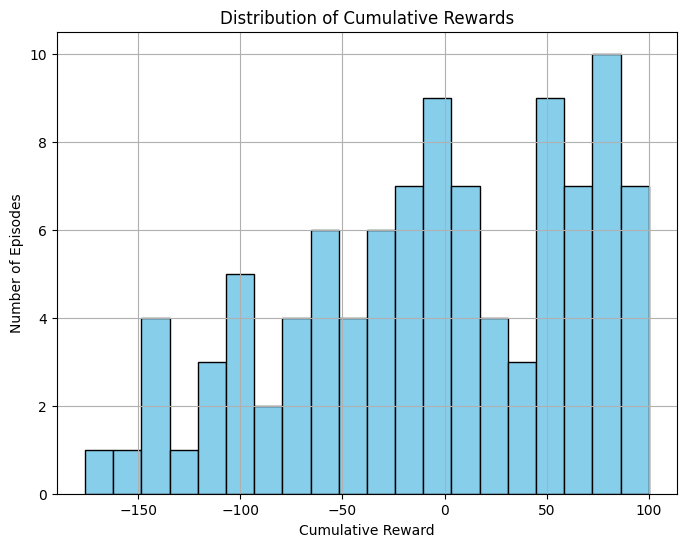

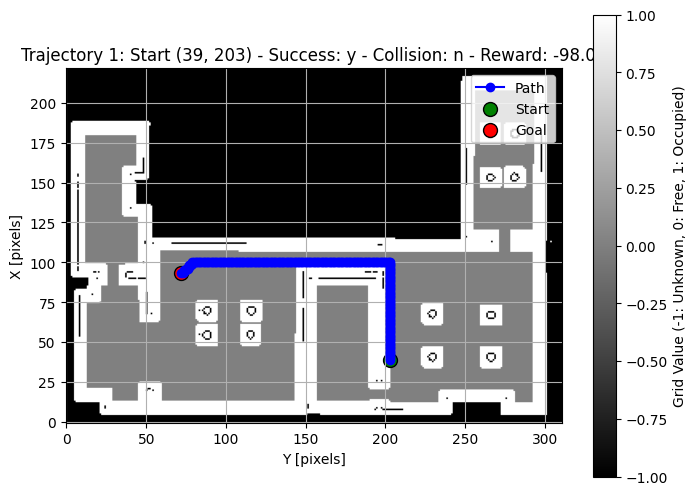

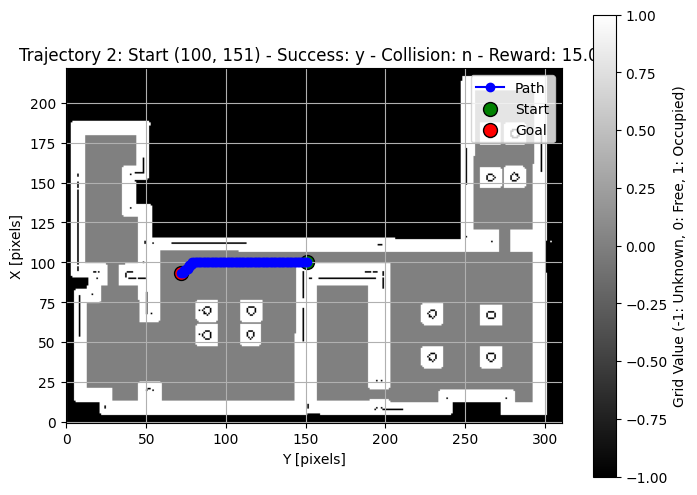

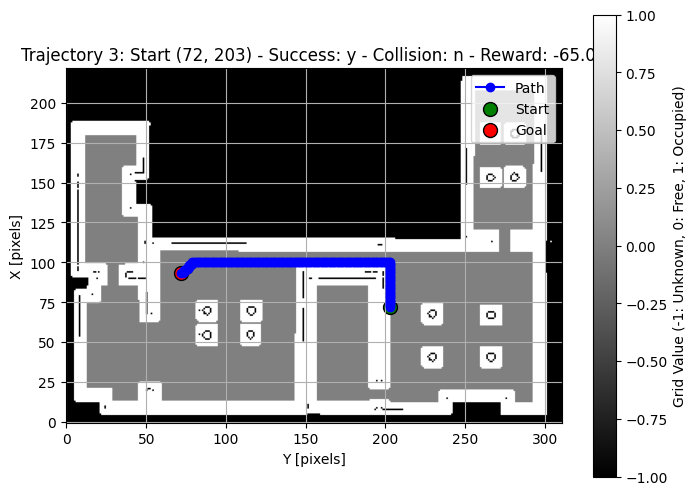

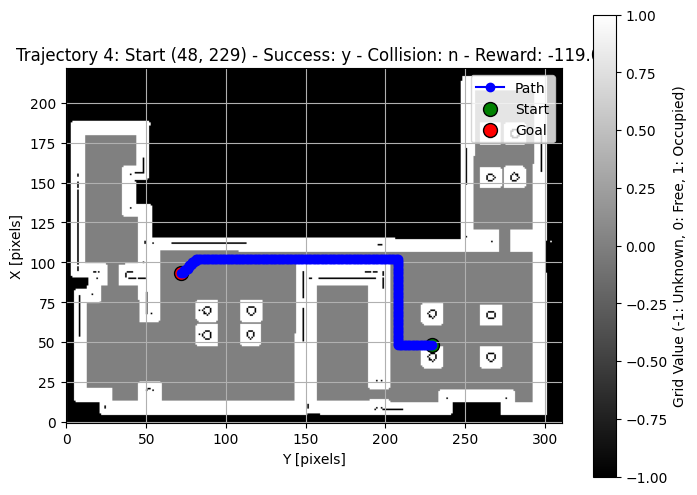

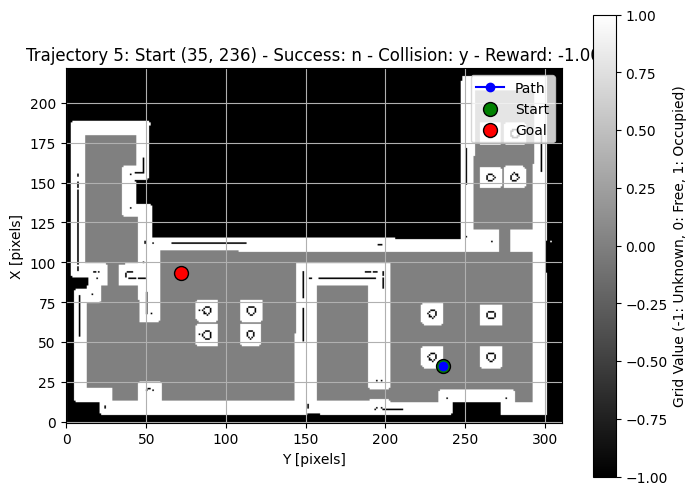

In [14]:
# -------------------------------
# Step 2: Import Libraries
# -------------------------------

import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
from scipy.ndimage import binary_dilation
from tqdm import tqdm

# -------------------------------
# Step 3: Define the Policy Network
# -------------------------------

# Define the Behavior Policy Model
class BehaviorPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, num_layers=3):
        super(BehaviorPolicy, self).__init__()
        layers = []
        input_dim = state_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, action_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, state):
        return self.model(state)

# -------------------------------
# Step 4: Define the RL Dataset Class
# -------------------------------

class RLDataset(Dataset):
    def __init__(self, data):
        """
        Initialize the dataset with states, actions, rewards, next_states, and done flags.

        Args:
            data (list): List of data entries, each being a dictionary with keys 's', 'a', 'r', 's\'', 'd'.
        """
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)
        self.rewards = torch.tensor([entry['r'] for entry in data], dtype=torch.float32)
        self.next_states = torch.tensor([entry["s'"] for entry in data], dtype=torch.float32)
        self.dones = torch.tensor([entry['d'] for entry in data], dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[idx]

# -------------------------------
# Step 5: Define Helper Functions
# -------------------------------

def process_map(image_path, occupied_threshold=50, free_threshold=240):
    """
    Process the map image into an occupancy grid.

    Args:
        image_path (str): Path to the map image.
        occupied_threshold (int): Pixel value below which is considered occupied.
        free_threshold (int): Pixel value above which is considered free.

    Returns:
        np.ndarray: Processed occupancy grid.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Map image not found at {image_path}.")
    map_image = Image.open(image_path).convert("L")
    map_array = np.array(map_image)
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # -1: Unknown
    occupancy_grid[map_array >= free_threshold] = 0           # 0: Free
    occupancy_grid[map_array <= occupied_threshold] = 1       # 1: Occupied
    print(f"Map processed: {occupancy_grid.shape[0]} rows, {occupancy_grid.shape[1]} columns.")
    return occupancy_grid

def inflate_obstacles(grid, inflation_radius_pixels):
    """
    Inflate obstacles in the occupancy grid to account for robot's size.

    Args:
        grid (np.ndarray): Original occupancy grid.
        inflation_radius_pixels (int): Number of pixels to inflate.

    Returns:
        np.ndarray: Inflated occupancy grid.
    """
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)
    occupied_mask = (grid == 1)
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)
    inflated_grid = np.copy(grid)
    inflated_grid[inflated_occupied & (grid == 0)] = 1  # Inflate free spaces to occupied
    print(f"Obstacles inflated by {inflation_radius_pixels} pixels.")
    return inflated_grid

def move_in_direction(state, action):
    """
    Map action index to movement direction and compute the next state.

    Args:
        state (tuple): Current state coordinates (x, y).
        action (int): Action index (0: Up, 1: Down, 2: Left, 3: Right).

    Returns:
        tuple: Next state coordinates (x, y).
    """
    # Define action mapping: 0-Up, 1-Down, 2-Left, 3-Right
    directions = {
        0: (-1, 0),  # Up
        1: (1, 0),   # Down
        2: (0, -1),  # Left
        3: (0, 1)    # Right
    }
    if action not in directions:
        raise ValueError(f"Invalid action index: {action}")
    dx, dy = directions[action]
    return (state[0] + dx, state[1] + dy)

def compute_reward(current_state, next_state, goal, done):
    """
    Compute the reward for transitioning from current_state to next_state.

    Args:
        current_state (tuple): Current state coordinates (x, y).
        next_state (tuple): Next state coordinates (x, y).
        goal (tuple): Goal coordinates (x, y).
        done (bool): Whether the episode has terminated.

    Returns:
        float: Calculated reward.
    """
    if next_state == goal:
        return 100  # Large reward for reaching the goal
    else:
        return -1   # Penalty for each step taken

def evaluate_single_trajectory(model, start_state, goal, grid, max_steps=1000, device="cpu"):
    """
    Simulate the policy from a single start state and collect trajectory data.

    Args:
        model (nn.Module): The trained policy network.
        start_state (tuple): Starting state coordinates (x, y).
        goal (tuple): Goal coordinates (x, y).
        grid (np.ndarray): Inflated occupancy grid.
        max_steps (int): Maximum steps per episode.
        device (torch.device): Device to run the model on.

    Returns:
        dict: Trajectory data containing start, goal, path, success, collision, and reward.
    """
    model.eval()
    current_state = start_state
    path = [current_state]
    success = False
    collision = False
    cumulative_reward = 0.0

    for step in range(max_steps):
        state_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(state_tensor)
            action = torch.argmax(logits, dim=1).item()

        next_state = move_in_direction(current_state, action)

        # Ensure next_state coordinates are integers
        next_state = (int(next_state[0]), int(next_state[1]))

        # Check boundaries
        if not (0 <= next_state[0] < grid.shape[0] and 0 <= next_state[1] < grid.shape[1]):
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        # Check collision
        if grid[next_state] == 1:
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        # Compute reward
        done = False
        if next_state == goal:
            success = True
            done = True
        reward = compute_reward(current_state, next_state, goal, done)
        cumulative_reward += reward

        path.append(next_state)
        current_state = next_state

        if done:
            break

    trajectory = {
        "Start": f"({start_state[0]}, {start_state[1]})",
        "Goal": f"({goal[0]}, {goal[1]})",
        "Path": path,
        "Success": "y" if success else "n",
        "Collision": "y" if collision else "n",
        "Reward Received": cumulative_reward
    }

    return trajectory

def visualize_path(grid, path, goal, title="Path Visualization"):
    """
    Visualize the robot's path on the occupancy grid.

    Args:
        grid (np.ndarray): Occupancy grid.
        path (list): List of state tuples representing the path.
        goal (tuple): Goal coordinates (x, y).
        title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray", origin="lower")
    plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")

    # Extract x and y coordinates from path
    x_coords, y_coords = zip(*path)
    plt.plot(y_coords, x_coords, marker='o', color='blue', label="Path")
    plt.scatter(y_coords[0], x_coords[0], color='green', s=100, label="Start", edgecolors="black")
    plt.scatter(goal[1], goal[0], color='red', s=100, label="Goal", edgecolors="black")

    plt.title(title)
    plt.xlabel("Y [pixels]")
    plt.ylabel("X [pixels]")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Step 6: Load Dataset and Process Map
# -------------------------------

# Define file paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
model_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/behavior_policy_tuned.pth"
map_path = "/content/sim_classroom_map_enhanced.pgm"
csv_output_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/tuned_behavior_policy_performance.csv"

# Define Goal Coordinates
goal = (93, 72)

# Define Inflation Radius
inflation_radius_pixels = 5

# Load and process the map
print("Processing map...")
occupancy_grid = process_map(map_path)
inflated_grid = inflate_obstacles(occupancy_grid, inflation_radius_pixels)

# Load the dataset
print("Loading dataset...")
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}.")
with open(dataset_path, "r") as f:
    rl_data = json.load(f)
print(f"Dataset loaded with {len(rl_data)} entries.")

# Initialize Dataset
full_dataset = RLDataset(rl_data)

# -------------------------------
# Step 7: Load the Trained Behavior Policy Model
# -------------------------------

# Define model parameters
state_dim = 2       # (x, y)
action_dim = 4      # up, down, left, right

# Initialize the model
behavior_policy = BehaviorPolicy(state_dim, action_dim, hidden_dim=256, num_layers=3)

# Load the trained model state
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Behavior Policy model not found at {model_path}.")
behavior_policy.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
behavior_policy.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
behavior_policy.eval()
print(f"Behavior Policy model loaded from {model_path}.")

# -------------------------------
# Step 8: Sample 100 Random Start Points
# -------------------------------

num_samples = 100
if len(full_dataset) < num_samples:
    print(f"Warning: Requested {num_samples} samples, but dataset has only {len(full_dataset)} samples. Using all samples.")
    sampled_indices = list(range(len(full_dataset)))
else:
    sampled_indices = random.sample(range(len(full_dataset)), num_samples)

sampled_entries = [full_dataset[i] for i in sampled_indices]

# -------------------------------
# Step 9: Evaluate the Behavior Policy
# -------------------------------

# Initialize list to store trajectory data
trajectories = []

# Initialize counters for metrics
success_count = 0
collision_count = 0
total_cumulative_reward = 0.0

# Evaluate each sampled start point
print("Evaluating Behavior Policy on sampled start points...")
for idx, (state, action, reward, next_state, done) in enumerate(tqdm(sampled_entries, desc="Evaluating Trajectories")):
    start_state = tuple(state.numpy().astype(int))  # Ensure integer coordinates
    trajectory = evaluate_single_trajectory(
        model=behavior_policy,
        start_state=start_state,
        goal=goal,
        grid=inflated_grid,
        max_steps=1000,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )

    # Update metrics
    if trajectory["Success"] == "y":
        success_count += 1
    if trajectory["Collision"] == "y":
        collision_count += 1
    total_cumulative_reward += trajectory["Reward Received"]

    # Append trajectory data
    trajectories.append({
        "Start": trajectory["Start"],
        "Goal": trajectory["Goal"],
        "Path": trajectory["Path"],
        "Success": trajectory["Success"],
        "Collision": trajectory["Collision"],
        "Reward Received": trajectory["Reward Received"]
    })

# -------------------------------
# Step 10: Compute and Display Metrics
# -------------------------------

success_rate = (success_count / num_samples) * 100
collision_rate = (collision_count / num_samples) * 100
average_cumulative_reward = total_cumulative_reward / num_samples

print("\nEvaluation Metrics:")
print(f"Success Rate: {success_rate:.2f}% ({success_count}/{num_samples})")
print(f"Collision Rate: {collision_rate:.2f}% ({collision_count}/{num_samples})")
print(f"Average Cumulative Reward: {average_cumulative_reward:.2f}")

# -------------------------------
# Step 11: Save Trajectory Data to CSV
# -------------------------------

# Convert trajectories to DataFrame
df_trajectories = pd.DataFrame(trajectories)

# Convert Path from list of tuples to string for CSV
df_trajectories['Path'] = df_trajectories['Path'].apply(lambda x: str(x))

# Save to CSV
df_trajectories.to_csv(csv_output_path, index=False)
print(f"Trajectory data saved to {csv_output_path}.")

# -------------------------------
# Step 12: Generate Meaningful Plots
# -------------------------------

# Plot Success vs. Collision
labels = ['Success', 'Collision']
counts = [success_count, collision_count]
plt.figure(figsize=(6,6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title("Evaluation Results")
plt.ylabel("Number of Episodes")
plt.show()

# Plot Distribution of Cumulative Rewards
plt.figure(figsize=(8,6))
plt.hist(df_trajectories['Reward Received'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Cumulative Rewards")
plt.xlabel("Cumulative Reward")
plt.ylabel("Number of Episodes")
plt.grid(True)
plt.show()

# -------------------------------
# Step 13: (Optional) Visualize a Few Sample Trajectories
# -------------------------------

# Visualize first 5 trajectories
for i in range(min(5, len(df_trajectories))):
    traj = df_trajectories.iloc[i]
    path = eval(traj['Path'])  # Convert string back to list of tuples
    visualize_path(
        grid=inflated_grid,
        path=path,
        goal=goal,
        title=f"Trajectory {i+1}: Start {traj['Start']} - Success: {traj['Success']} - Collision: {traj['Collision']} - Reward: {traj['Reward Received']:.2f}"
    )


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from collections import deque, namedtuple
from torch.optim import Adam
import random
import optuna
from sklearn.model_selection import train_test_split

# Define Critic (Q-function)
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, state):
        return self.model(state)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, device):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device
        self.experience = namedtuple(
            "Experience", field_names=["state", "action", "reward", "next_state", "done"]
        )

    def add(self, state, action, reward, next_state, done):
        # Convert state and next_state to numpy arrays for consistency
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in buffer to sample")
        experiences = random.sample(self.memory, self.batch_size)

        states = torch.tensor(
            np.stack([e.state for e in experiences]), dtype=torch.float32
        ).to(self.device)

        actions = torch.tensor(
            np.array([e.action for e in experiences]), dtype=torch.long
        ).to(self.device)

        rewards = torch.tensor(
            np.array([e.reward for e in experiences]), dtype=torch.float32
        ).to(self.device)

        next_states = torch.tensor(
            np.stack([e.next_state for e in experiences]), dtype=torch.float32
        ).to(self.device)

        dones = torch.tensor(
            np.array([e.done for e in experiences]), dtype=torch.float32
        ).to(self.device)

        return states, actions, rewards, next_states, dones

# Conservative Q-Learning Loss
def cql_loss(critic, target_critic, states, actions, rewards, next_states, dones, gamma, alpha):
    # Q-values for actions taken
    q_values = critic(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

    # Target Q-values
    with torch.no_grad():
        target_q_values = target_critic(next_states).max(1)[0]
        target_q = rewards + gamma * (1 - dones) * target_q_values

    # Bellman error
    bellman_loss = F.mse_loss(q_values, target_q)

    # Conservative regularization
    all_q_values = critic(states)
    log_sum_exp_q = torch.logsumexp(all_q_values, dim=1)
    dataset_q_values = q_values
    conservative_loss = log_sum_exp_q.mean() - dataset_q_values.mean()

    # Combined loss
    total_loss = bellman_loss + alpha * conservative_loss
    return total_loss

# Load Dataset and Split into Training and Validation
def load_and_split_dataset(file_path, test_size=0.2, random_state=42):
    with open(file_path, 'r') as f:
        data = json.load(f)
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=random_state)
    return train_data, val_data

# Training Loop
def train_cql(train_data, val_data, state_size, action_size, hidden_size, batch_size, buffer_size,
             gamma, alpha, learning_rate, num_epochs, device):
    # Initialize replay buffers for training and validation
    train_buffer = ReplayBuffer(buffer_size, batch_size, device)
    val_buffer = ReplayBuffer(buffer_size, batch_size, device)

    # Populate training buffer
    for sample in train_data:
        train_buffer.add(
            sample['s'],              # State
            sample['a'],              # Action
            sample['r'],              # Reward
            sample["s'"],             # Next state
            float(sample['d'])        # Done flag as float
        )

    # Populate validation buffer
    for sample in val_data:
        val_buffer.add(
            sample['s'],              # State
            sample['a'],              # Action
            sample['r'],              # Reward
            sample["s'"],             # Next state
            float(sample['d'])        # Done flag as float
        )

    # Initialize models
    critic = Critic(state_size, action_size, hidden_size).to(device)
    target_critic = Critic(state_size, action_size, hidden_size).to(device)
    target_critic.load_state_dict(critic.state_dict())

    # Optimizer
    optimizer = Adam(critic.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        try:
            states, actions, rewards, next_states, dones = train_buffer.sample()
        except ValueError as e:
            print(f"Epoch {epoch + 1}/{num_epochs}: {str(e)}")
            continue

        loss = cql_loss(critic, target_critic, states, actions, rewards, next_states, dones, gamma, alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update target network
        with torch.no_grad():
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)

        # Validation step
        try:
            val_states, val_actions, val_rewards, val_next_states, val_dones = val_buffer.sample()
            val_loss = cql_loss(critic, target_critic, val_states, val_actions, val_rewards, val_next_states, val_dones, gamma, alpha)
        except ValueError:
            val_loss = None  # Not enough samples in validation buffer

        # Logging
        if (epoch + 1) % 10 == 0 or epoch == 0:
            if val_loss is not None:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: N/A")

    # After training, evaluate on validation set
    # You can extend this part based on how you want to evaluate your model
    # For example, compute average Q-values, or implement policy evaluation
    return critic

# Objective Function for Optuna
def objective(trial):
    # Hyperparameter search space
    hidden_size = trial.suggest_categorical('hidden_size', [128, 256, 512])
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1.0)
    gamma = 0.99  # Typically fixed
    num_epochs = 100  # You can also make this a hyperparameter if needed

    # Load and split dataset
    train_data, val_data = load_and_split_dataset('/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json')

    # Define other parameters
    state_size = 2  # (x, y) coordinates
    action_size = 4  # up, down, left, right
    buffer_size = 100000  # Can also be tuned if needed
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Train CQL model
    trained_critic = train_cql(
        train_data=train_data,
        val_data=val_data,
        state_size=state_size,
        action_size=action_size,
        hidden_size=hidden_size,
        batch_size=batch_size,
        buffer_size=buffer_size,
        gamma=gamma,
        alpha=alpha,
        learning_rate=learning_rate,
        num_epochs=num_epochs,
        device=device
    )

    # Evaluate the model
    # For simplicity, we'll use the average Q-value on the validation set as the metric
    try:
        val_buffer = ReplayBuffer(buffer_size, batch_size, device)
        for sample in val_data:
            val_buffer.add(
                sample['s'],
                sample['a'],
                sample['r'],
                sample["s'"],
                float(sample['d'])
            )
        states, actions, rewards, next_states, dones = val_buffer.sample()
        q_values = trained_critic(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        avg_q = q_values.mean().item()
    except Exception as e:
        avg_q = -np.inf  # Assign a poor score if evaluation fails

    # Since Optuna minimizes the objective, we want to maximize avg_q
    # Therefore, return the negative average Q-value
    return -avg_q

# Run Optuna Study
def run_optuna():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)  # Adjust n_trials as needed

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

# Main Function with Optuna Integration
if __name__ == "__main__":
    run_optuna()


ModuleNotFoundError: No module named 'optuna'

# Script Overview

This script implements Conservative Q-Learning (CQL) for reinforcement learning using PyTorch and Optuna for hyperparameter optimization. It trains a critic (Q-function), evaluates it, and uses replay buffers for efficient data handling.

---

## **Step 1: Import Libraries**
- Includes essential libraries:
  - `torch` for deep learning.
  - `numpy` and `json` for data processing.
  - `optuna` for hyperparameter optimization.
  - `sklearn` for dataset splitting.

---

## **Step 2: Define Critic (Q-function)**
- Implements a fully connected neural network to estimate Q-values.
- Configurable hidden layers and activations.

---

## **Step 3: Define Replay Buffer**
- A replay buffer stores state-action transitions for training.
- Supports efficient sampling of mini-batches for training and validation.

---

## **Step 4: Conservative Q-Learning Loss**
- **`cql_loss`**:
  - Combines Bellman error with a conservative regularization term.
  - Encourages realistic Q-value estimates by penalizing overestimation.

---

## **Step 5: Load and Split Dataset**
- **`load_and_split_dataset`**:
  - Loads RL dataset from a JSON file.
  - Splits the data into training and validation subsets.

---

## **Step 6: Training Loop**
- **`train_cql`**:
  - Trains the critic model using mini-batches from the replay buffer.
  - Regularly updates the target Q-network.
  - Computes and logs training and validation losses.

---

## **Step 7: Optuna Integration**
- **`objective`**:
  - Defines the search space for hyperparameters (`hidden_size`, `batch_size`, `learning_rate`, `alpha`).
  - Trains the model using the selected hyperparameters.
  - Evaluates the average Q-value on the validation set as the performance metric.
- **`run_optuna`**:
  - Runs the Optuna study to find the best hyperparameter configuration.
  - Logs the best parameters and their corresponding validation performance.

---

## **Step 8: Main Execution**
- Executes Optuna hyperparameter optimization with 50 trials.
- Logs the best hyperparameters and their performance.

---

## **Key Outputs**
- **Hyperparameter Optimization**:
  - Best `hidden_size`, `batch_size`, `learning


In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from collections import deque, namedtuple
from torch.optim import Adam
import random
import os

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Define Actor (Behavior Policy)
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_sizes):
        super(Actor, self).__init__()
        layers = []
        input_size = state_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, action_size))
        layers.append(nn.Softmax(dim=-1))
        self.model = nn.Sequential(*layers)

    def forward(self, state):
        return self.model(state)

# Define Critic (Q-function)
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, state):
        return self.model(state)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, device):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.device = device
        self.experience = namedtuple(
            "Experience", field_names=["state", "action", "reward", "next_state", "done"]
        )

    def add(self, state, action, reward, next_state, done):
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in buffer to sample")
        experiences = random.sample(self.memory, self.batch_size)
        states = torch.tensor(
            np.stack([e.state for e in experiences]), dtype=torch.float32
        ).to(self.device)
        actions = torch.tensor(
            np.array([e.action for e in experiences]), dtype=torch.long
        ).to(self.device)
        rewards = torch.tensor(
            np.array([e.reward for e in experiences]), dtype=torch.float32
        ).to(self.device)
        next_states = torch.tensor(
            np.stack([e.next_state for e in experiences]), dtype=torch.float32
        ).to(self.device)
        dones = torch.tensor(
            np.array([e.done for e in experiences]), dtype=torch.float32
        ).to(self.device)
        return states, actions, rewards, next_states, dones

# Conservative Q-Learning Loss
def cql_loss(critic, target_critic, states, actions, rewards, next_states, dones, gamma, alpha):
    q_values = critic(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    with torch.no_grad():
        target_q_values = target_critic(next_states).max(1)[0]
        target_q = rewards + gamma * (1 - dones) * target_q_values
    bellman_loss = F.mse_loss(q_values, target_q)
    all_q_values = critic(states)
    log_sum_exp_q = torch.logsumexp(all_q_values, dim=1)
    dataset_q_values = q_values
    conservative_loss = log_sum_exp_q.mean() - dataset_q_values.mean()
    total_loss = bellman_loss + alpha * conservative_loss
    return total_loss

# Modified Reward Function
def compute_reward(current_state, next_state, goal, collision):
    """
    Compute the reward based on distance to the goal, collisions, and goal-reaching.
    """
    current_dist = np.linalg.norm(np.array(current_state) - np.array(goal))
    next_dist = np.linalg.norm(np.array(next_state) - np.array(goal))

    if collision:
        return -100  # Heavy penalty for collision
    if next_state == goal:
        return 100  # Large reward for reaching the goal
    return current_dist - next_dist  # Reward for reducing distance

# Load Dataset and Split into Training and Validation
def load_and_split_dataset(file_path, test_size=0.2, random_state=42):
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Modify rewards using the updated reward function
    goal = (93, 72)  # Goal is fixed for all trajectories
    for entry in data:
        current_state = tuple(entry['s'])
        next_state = tuple(entry["s'"])
        collision = entry['d'] == 1  # Assuming 'd' can represent collisions
        entry['r'] = compute_reward(current_state, next_state, goal, collision)

    random.seed(random_state)
    random.shuffle(data)
    split_idx = int(len(data) * (1 - test_size))
    train_data = data[:split_idx]
    val_data = data[split_idx:]
    return train_data, val_data

# Training Loop
def train_cql(train_data, val_data, actor, critic, target_critic, buffer_size, batch_size,
              gamma, alpha, learning_rate, num_epochs, device):
    train_buffer = ReplayBuffer(buffer_size, batch_size, device)
    val_buffer = ReplayBuffer(buffer_size, batch_size, device)

    for sample in train_data:
        train_buffer.add(sample['s'], sample['a'], sample['r'], sample["s'"], float(sample['d']))
    for sample in val_data:
        val_buffer.add(sample['s'], sample['a'], sample['r'], sample["s'"], float(sample['d']))

    optimizer = Adam(critic.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        states, actions, rewards, next_states, dones = train_buffer.sample()
        loss = cql_loss(critic, target_critic, states, actions, rewards, next_states, dones, gamma, alpha)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(0.995 * target_param.data + 0.005 * param.data)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    return critic

# Main Function
def main():
    dataset_path = '/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json'
    behavior_policy_path = '/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/behavior_policy_tuned.pth'
    state_size = 2
    action_size = 4
    best_hyperparams = {
        'hidden_size': [256, 256, 256],  # Match saved Actor architecture
        'batch_size': 256,
        'learning_rate': 0.0013687788243744378,
        'alpha': 0.0007054525963520176
    }
    buffer_size = 100000
    num_epochs = 100
    gamma = 0.99
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    print("Loading and splitting dataset...")
    train_data, val_data = load_and_split_dataset(dataset_path, test_size=0.2)
    print(f"Training data: {len(train_data)} samples")
    print(f"Validation data: {len(val_data)} samples")

    print("Initializing Actor...")
    actor = Actor(state_size, action_size, best_hyperparams['hidden_size']).to(device)
    actor.load_state_dict(torch.load(behavior_policy_path, map_location=device))  # Adjusted to load weights directly
    actor.eval()
    print("Actor initialized.")

    print("Initializing Critic and Target Critic...")
    critic = Critic(state_size, action_size, 512).to(device)
    target_critic = Critic(state_size, action_size, 512).to(device)
    target_critic.load_state_dict(critic.state_dict())
    print("Critic initialized.")

    trained_critic = train_cql(
        train_data=train_data,
        val_data=val_data,
        actor=actor,
        critic=critic,
        target_critic=target_critic,
        buffer_size=buffer_size,
        batch_size=best_hyperparams['batch_size'],
        gamma=gamma,
        alpha=best_hyperparams['alpha'],
        learning_rate=best_hyperparams['learning_rate'],
        num_epochs=num_epochs,
        device=device
    )

    save_dir = '/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/'
    os.makedirs(save_dir, exist_ok=True)
    torch.save(trained_critic.state_dict(), os.path.join(save_dir, 'trained_critic_cql.pth'))
    print("Model saved.")

if __name__ == "__main__":
    main()


Loading and splitting dataset...
Training data: 1253545 samples
Validation data: 313387 samples
Initializing Actor...
Actor initialized.
Initializing Critic and Target Critic...
Critic initialized.


<ipython-input-82-f878ae198ea2>:190: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Epoch 1/100, Loss: 360.7081
Epoch 2/100, Loss: 5385.9663
Epoch 3/100, Loss: 659.9927
Epoch 4/100, Loss: 853.9812
Epoch 5/100, Loss: 1756.7214
Epoch 6/100, Loss: 1712.8403
Epoch 7/100, Loss: 751.9971
Epoch 8/100, Loss: 155.9065
Epoch 9/100, Loss: 137.5539
Epoch 10/100, Loss: 347.6702
Epoch 11/100, Loss: 724.4472
Epoch 12/100, Loss: 616.8088
Epoch 13/100, Loss: 528.8623
Epoch 14/100, Loss: 215.5997
Epoch 15/100, Loss: 103.9740
Epoch 16/100, Loss: 214.2898
Epoch 17/100, Loss: 92.9196
Epoch 18/100, Loss: 243.2032
Epoch 19/100, Loss: 295.3339
Epoch 20/100, Loss: 234.4621
Epoch 21/100, Loss: 219.5783
Epoch 22/100, Loss: 133.5131
Epoch 23/100, Loss: 47.2542
Epoch 24/100, Loss: 97.2372
Epoch 25/100, Loss: 96.1456
Epoch 26/100, Loss: 32.1099
Epoch 27/100, Loss: 145.3231
Epoch 28/100, Loss: 130.8267
Epoch 29/100, Loss: 155.3445
Epoch 30/100, Loss: 89.3692
Epoch 31/100, Loss: 76.0186
Epoch 32/100, Loss: 55.2132
Epoch 33/100, Loss: 92.9524
Epoch 34/100, Loss: 208.5839
Epoch 35/100, Loss: 56.1906
E

# Script Overview

This script implements Conservative Q-Learning (CQL) to evaluate a trained Q-function (critic) model in a Gazebo-based grid-world environment. It processes the map, inflates obstacles, samples and evaluates trajectories, and calculates key metrics like success and collision rates.

---

## **Step 1: Import Libraries**
- Includes libraries for:
  - Neural network implementation: `torch`.
  - Data processing and visualization: `numpy`, `pandas`, `matplotlib`.
  - Simulation utilities: `PIL`, `tqdm`.

---

## **Step 2: Define the Critic Network**
- A fully connected neural network maps states to Q-values for all possible actions.
- Configurable hidden layers enable scalability to different state and action spaces.

---

## **Step 3: Define the RL Dataset**
- `RLDataset` class organizes state, action, reward, next state, and done flags.
- Supports PyTorch's `DataLoader` for efficient batch processing.

---

## **Step 4: Helper Functions**
- **`process_map`**:
  - Converts a grayscale `.pgm` map into an occupancy grid.
  - Labels grid cells as free (0), occupied (1), or unknown (-1).
- **`inflate_obstacles`**:
  - Expands obstacles in the occupancy grid to account for the robot's size.
- **`move_in_direction`**:
  - Maps actions (up, down, left, right) to state transitions.
- **`compute_reward`**:
  - Assigns rewards based on proximity to the goal and penalties for collisions.
- **`evaluate_single_trajectory`**:
  - Simulates a trajectory from a start state to the goal, collecting metrics such as success, collision, and cumulative reward.
- **`visualize_path`**:
  - Plots trajectories on the occupancy grid, highlighting start and goal points.

---

## **Step 5: Load and Process the Map**
- Loads and processes the map into a grid representation.
- Inflates obstacles using a configurable pixel radius.

---

## **Step 6: Load Dataset**
- Loads RL dataset from a JSON file.
- Structures the data into a PyTorch-compatible format using `RLDataset`.

---

## **Step 7: Load Trained CQL Critic Model**
- Initializes and loads a pre-trained critic model (Q-function).
- Evaluates the model on sampled trajectories.

---

## **Step 8: Evaluate Trajectories**
- Samples 100 random start points from the dataset.
- Evaluates each start point using the trained critic model:
  - Measures success rate: Percentage of trajectories reaching the goal.
  - Tracks collision rate: Percentage of trajectories that collide with obstacles.
  - Calculates average cumulative reward.

---

## **Step 9: Compute Metrics**
- Logs evaluation results:
  - **Success Rate**: \( \text{(successful trajectories / total)} \times 100 \).
  - **Collision Rate**: \( \text{(collided trajectories / total)} \times 100 \).
  - **Average Reward**: Mean cumulative reward across all trajectories.

---

## **Step 10: Save Results**
- Saves trajectory data, including:
  - Start and goal states.
  - Path details.
  - Success and collision status.
  - Reward received.
- Results are exported to a CSV file for further analysis.

---

## **Key Outputs**
- **Evaluation Metrics**:
  - Success rate.
  - Collision rate.
  - Average cumulative reward.
- **Trajectory Data**:
  - CSV file with detailed trajectory information.
- **Visualizations**:
  - Path trajectories on the grid.

---

## **Customizable Parameters**
- **Map and Dataset**:
  - Update `map_path` and `dataset_path` for different environments and datasets.
- **Evaluation Parameters**:
  - Adjust `num_samples` to test more or fewer start points.
  - Modify `inflation_radius_pixels` based on the robot's size.
- **Goal Position**:
  - Change the `goal` variable to set a new target location.

This script offers a robust framework to evaluate Q-learning policies in grid-world navigation tasks, enabling seamless integration with other RL components.


## Code to Evaluate CQL Performance

In [85]:
# -------------------------------
# Step 2: Import Libraries
# -------------------------------

import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
from scipy.ndimage import binary_dilation
from tqdm import tqdm

# -------------------------------
# Step 3: Define the Critic Network (Q-Function)
# -------------------------------

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state):
        return self.model(state)

# -------------------------------
# Step 4: Define the RL Dataset Class
# -------------------------------

class RLDataset(Dataset):
    def __init__(self, data):
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)
        self.rewards = torch.tensor([entry['r'] for entry in data], dtype=torch.float32)
        self.next_states = torch.tensor([entry["s'"] for entry in data], dtype=torch.float32)
        self.dones = torch.tensor([entry['d'] for entry in data], dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[idx]

# -------------------------------
# Step 5: Define Helper Functions
# -------------------------------

def process_map(image_path, occupied_threshold=50, free_threshold=240):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Map image not found at {image_path}.")
    map_image = Image.open(image_path).convert("L")
    map_array = np.array(map_image)
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # -1: Unknown
    occupancy_grid[map_array >= free_threshold] = 0           # 0: Free
    occupancy_grid[map_array <= occupied_threshold] = 1       # 1: Occupied
    print(f"Map processed: {occupancy_grid.shape[0]} rows, {occupancy_grid.shape[1]} columns.")
    return occupancy_grid

def inflate_obstacles(grid, inflation_radius_pixels):
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)
    occupied_mask = (grid == 1)
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)
    inflated_grid = np.copy(grid)
    inflated_grid[inflated_occupied & (grid == 0)] = 1
    print(f"Obstacles inflated by {inflation_radius_pixels} pixels.")
    return inflated_grid

def move_in_direction(state, action):
    directions = {
        0: (-1, 0),  # Up
        1: (1, 0),   # Down
        2: (0, -1),  # Left
        3: (0, 1)    # Right
    }
    if action not in directions:
        raise ValueError(f"Invalid action index: {action}")
    dx, dy = directions[action]
    return (state[0] + dx, state[1] + dy)

def compute_reward(current_state, next_state, goal, collision, done=False):
    current_dist = np.linalg.norm(np.array(current_state) - np.array(goal))
    next_dist = np.linalg.norm(np.array(next_state) - np.array(goal))
    if collision:
        return -100
    if done and next_state == goal:
        return 100
    return current_dist - next_dist

def evaluate_single_trajectory(model, start_state, goal, grid, max_steps=1000, device="cpu"):
    model.eval()
    current_state = start_state
    path = [current_state]
    success = False
    collision = False
    cumulative_reward = 0.0

    for step in range(max_steps):
        state_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

        next_state = move_in_direction(current_state, action)
        next_state = (int(next_state[0]), int(next_state[1]))

        if not (0 <= next_state[0] < grid.shape[0] and 0 <= next_state[1] < grid.shape[1]):
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, collision=True, done=True)
            break

        if grid[next_state] == 1:
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, collision=True, done=True)
            break

        done = False
        if next_state == goal:
            success = True
            done = True

        reward = compute_reward(current_state, next_state, goal, collision=False, done=done)
        cumulative_reward += reward

        path.append(next_state)
        current_state = next_state

        if done:
            break

    trajectory = {
        "Start": f"({start_state[0]}, {start_state[1]})",
        "Goal": f"({goal[0]}, {goal[1]})",
        "Path": path,
        "Success": "y" if success else "n",
        "Collision": "y" if collision else "n",
        "Reward Received": cumulative_reward
    }

    return trajectory

def visualize_path(grid, path, goal, title="Path Visualization"):
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray", origin="lower")
    plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")
    x_coords, y_coords = zip(*path)
    plt.plot(y_coords, x_coords, marker='o', color='blue', label="Path")
    plt.scatter(y_coords[0], x_coords[0], color='green', s=100, label="Start", edgecolors="black")
    plt.scatter(goal[1], goal[0], color='red', s=100, label="Goal", edgecolors="black")
    plt.title(title)
    plt.xlabel("Y [pixels]")
    plt.ylabel("X [pixels]")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Main Script
# -------------------------------

dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
model_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/trained_critic_cql.pth"
map_path = "/content/sim_classroom_map_enhanced.pgm"
csv_output_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/cql_critic_performance.csv"
goal = (93, 72)
inflation_radius_pixels = 5

print("Processing map...")
occupancy_grid = process_map(map_path)
inflated_grid = inflate_obstacles(occupancy_grid, inflation_radius_pixels)

print("Loading dataset...")
with open(dataset_path, "r") as f:
    rl_data = json.load(f)

full_dataset = RLDataset(rl_data)
state_dim, action_dim = 2, 4

print("Loading trained CQL Critic model...")
critic_model = Critic(state_dim, action_dim, hidden_dim=512)
critic_model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
critic_model.to("cuda" if torch.cuda.is_available() else "cpu")
critic_model.eval()

print("Sampling and evaluating trajectories...")
num_samples = 100
sampled_indices = random.sample(range(len(full_dataset)), num_samples)
sampled_entries = [full_dataset[i] for i in sampled_indices]

trajectories = []
success_count, collision_count, total_cumulative_reward = 0, 0, 0.0

for state, action, reward, next_state, done in tqdm(sampled_entries):
    start_state = tuple(state.numpy().astype(int))
    trajectory = evaluate_single_trajectory(critic_model, start_state, goal, inflated_grid, device="cuda" if torch.cuda.is_available() else "cpu")
    trajectories.append(trajectory)
    if trajectory["Success"] == "y":
        success_count += 1
    if trajectory["Collision"] == "y":
        collision_count += 1
    total_cumulative_reward += trajectory["Reward Received"]

success_rate = (success_count / num_samples) * 100
collision_rate = (collision_count / num_samples) * 100
average_reward = total_cumulative_reward / num_samples

print(f"\nEvaluation Metrics:\nSuccess Rate: {success_rate}%\nCollision Rate: {collision_rate}%\nAverage Reward: {average_reward}")
df_trajectories = pd.DataFrame(trajectories)
df_trajectories.to_csv(csv_output_path, index=False)
print(f"Trajectories saved to {csv_output_path}.")


Processing map...
Map processed: 222 rows, 311 columns.
Obstacles inflated by 5 pixels.
Loading dataset...


<ipython-input-85-31ae4c594110>:190: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Loading trained CQL Critic model...
Sampling and evaluating trajectories...


100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Evaluation Metrics:
Success Rate: 0.0%
Collision Rate: 49.0%
Average Reward: -58.8686562129772
Trajectories saved to /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/cql_critic_performance.csv.


## Code for AWR hyperparameter tuning and training

In [18]:
# -------------------------------
# Step 1: Import Libraries
# -------------------------------
import os
import json
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import optuna
from tqdm import tqdm
import random
import pandas as pd

# -------------------------------
# Step 2: Define the Policy Network
# -------------------------------
class AWRPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256, num_layers=3):
        super(AWRPolicy, self).__init__()
        layers = []
        input_dim = state_dim
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, action_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, state):
        return self.model(state)

# -------------------------------
# Step 3: Define Dataset and Helpers
# -------------------------------
class RLDataset(Dataset):
    def __init__(self, data):
        """
        Initialize the dataset with states, actions, rewards, next_states, and done flags.

        Args:
            data (list): List of data entries, each being a dictionary with keys 's', 'a', 'r', 's\'', 'd'.
        """
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)
        self.rewards = torch.tensor([entry['r'] for entry in data], dtype=torch.float32)
        self.next_states = torch.tensor([entry["s'"] for entry in data], dtype=torch.float32)
        self.dones = torch.tensor([entry['d'] for entry in data], dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return (
            self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_states[idx],
            self.dones[idx],
        )


def compute_advantages(rewards, gamma):
    advantages = []
    cumulative = 0
    for r in reversed(rewards):
        cumulative = r + gamma * cumulative
        advantages.insert(0, cumulative)
    return np.array(advantages)

def evaluate_policy(model, dataset, gamma, device):
    """
    Evaluate the policy on the dataset and calculate the success rate and cumulative reward.
    """
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
    model.eval()
    success_count, total_reward = 0, 0
    for states, actions, *_ in dataloader:  # Ignore extra values
        states = states.to(device)
        logits = model(states)
        predicted_actions = torch.argmax(logits, dim=1)
        success_count += (predicted_actions == actions.to(device)).sum().item()
        total_reward += (gamma ** torch.arange(actions.size(0), device=device)).sum().item()  # Example reward calculation
    success_rate = success_count / len(dataset)
    return success_rate


# -------------------------------
# Step 4: Define AWR Training Loop
# -------------------------------
def train_awr(model, dataset, beta, gamma, learning_rate, num_epochs=10, batch_size=64, device="cpu"):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for states, actions, rewards, next_states, dones in dataloader:
            states = states.to(device)
            actions = actions.to(device)
            rewards = rewards.to(device)
            next_states = next_states.to(device)
            dones = dones.to(device)

            # Forward pass
            logits = model(states)
            log_probs = torch.log_softmax(logits, dim=-1)
            selected_log_probs = log_probs.gather(1, actions.unsqueeze(-1)).squeeze(-1)

            # Advantage calculation
            with torch.no_grad():
                advantages = rewards + gamma * (1 - dones) * torch.max(logits, dim=1)[0]

            # Exponential weighting
            weights = torch.exp(advantages / beta).detach()
            weights = torch.clamp(weights, max=10.0)  # Avoid exploding gradients

            # Weighted loss
            weighted_loss = -(weights * selected_log_probs).mean()

            optimizer.zero_grad()
            weighted_loss.backward()
            optimizer.step()

            total_loss += weighted_loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")



# -------------------------------
# Step 5: Define Optuna Objective
# -------------------------------
def objective(trial):
    beta = trial.suggest_float("beta", 0.1, 1.0)
    gamma = trial.suggest_float("gamma", 0.9, 0.99)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512])
    num_layers = trial.suggest_int("num_layers", 1, 3)

    model = AWRPolicy(state_dim=2, action_dim=4, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
    train_awr(model, train_dataset, beta, gamma, learning_rate, num_epochs=5, device=device)
    success_rate = evaluate_policy(model, val_dataset, gamma, device)
    return success_rate

# -------------------------------
# Step 6: Load Data and Run Optuna
# -------------------------------
dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
output_dir = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

with open(dataset_path, 'r') as f:
    data = json.load(f)

random.shuffle(data)
split_idx = int(0.8 * len(data))
train_data, val_data = data[:split_idx], data[split_idx:]
train_dataset = RLDataset(train_data)
val_dataset = RLDataset(val_data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

# -------------------------------
# Step 7: Train Final Model
# -------------------------------
final_model = AWRPolicy(state_dim=2, action_dim=4, hidden_dim=best_params["hidden_dim"], num_layers=best_params["num_layers"]).to(device)
train_awr(final_model, train_dataset, best_params["beta"], best_params["gamma"], best_params["learning_rate"], num_epochs=50, device=device)

# -------------------------------
# Step 8: Save and Visualize Results
# -------------------------------
torch.save(final_model.state_dict(), os.path.join(output_dir, "final_awr_model.pth"))

success_rate = evaluate_policy(final_model, val_dataset, best_params["gamma"], device)
print(f"Final Model Success Rate: {success_rate:.2f}%")

optuna.visualization.plot_optimization_history(study).write_image(os.path.join(output_dir, "optuna_optimization_history.png"))
optuna.visualization.plot_param_importances(study).write_image(os.path.join(output_dir, "optuna_param_importances.png"))

print(f"Plots saved to {output_dir}")


[I 2024-12-09 10:01:38,655] A new study created in memory with name: no-name-54287ed9-d8bc-4834-a109-a93682da2c26
<ipython-input-18-b0d04726eec3>:138: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


Epoch 1/5, Loss: 59796.3624
Epoch 2/5, Loss: 33914.3545
Epoch 3/5, Loss: 29285.6295
Epoch 4/5, Loss: 26879.7744
Epoch 5/5, Loss: 26286.0780


[I 2024-12-09 10:06:42,667] Trial 0 finished with value: 0.8952126284753356 and parameters: {'beta': 0.10527186860968374, 'gamma': 0.9598285812344246, 'learning_rate': 0.0017199761126502574, 'hidden_dim': 128, 'num_layers': 3}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 144973.3215
Epoch 2/5, Loss: 105727.6025
Epoch 3/5, Loss: 86959.2465
Epoch 4/5, Loss: 72254.1292
Epoch 5/5, Loss: 59818.5458


[I 2024-12-09 10:11:07,053] Trial 1 finished with value: 0.8582264101574092 and parameters: {'beta': 0.580491542694846, 'gamma': 0.9226055741912702, 'learning_rate': 0.0008214506108545856, 'hidden_dim': 256, 'num_layers': 1}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 84754.2484
Epoch 2/5, Loss: 44419.7380
Epoch 3/5, Loss: 50024.3149
Epoch 4/5, Loss: 48822.4933
Epoch 5/5, Loss: 54564.4297


[I 2024-12-09 10:15:31,849] Trial 2 finished with value: 0.7092731989520944 and parameters: {'beta': 0.6601136285613838, 'gamma': 0.9488186517150676, 'learning_rate': 0.008799479587999419, 'hidden_dim': 128, 'num_layers': 1}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 32077.4376
Epoch 2/5, Loss: 24650.1728
Epoch 3/5, Loss: 28759.6680
Epoch 4/5, Loss: 24344.5078
Epoch 5/5, Loss: 24360.4626


[I 2024-12-09 10:20:15,395] Trial 3 finished with value: 0.8473389132286917 and parameters: {'beta': 0.7692100388001486, 'gamma': 0.9539721100604379, 'learning_rate': 0.0021204522842418498, 'hidden_dim': 128, 'num_layers': 2}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 117652.4148
Epoch 2/5, Loss: 99239.7178
Epoch 3/5, Loss: 93428.2215
Epoch 4/5, Loss: 88533.7622
Epoch 5/5, Loss: 84511.6538


[I 2024-12-09 10:24:40,606] Trial 4 finished with value: 0.8099857364855594 and parameters: {'beta': 0.7750604146722382, 'gamma': 0.9099785970187393, 'learning_rate': 0.00011016183966350152, 'hidden_dim': 512, 'num_layers': 1}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 151545.3016
Epoch 2/5, Loss: 120204.2428
Epoch 3/5, Loss: 102778.7385
Epoch 4/5, Loss: 92130.0879
Epoch 5/5, Loss: 83609.5747


[I 2024-12-09 10:29:06,025] Trial 5 finished with value: 0.8215688589507542 and parameters: {'beta': 0.10503531690296079, 'gamma': 0.9760845492994991, 'learning_rate': 0.00046450837731381396, 'hidden_dim': 512, 'num_layers': 1}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 31106.3849
Epoch 2/5, Loss: 30686.9152
Epoch 3/5, Loss: 21696.7332
Epoch 4/5, Loss: 21586.1198
Epoch 5/5, Loss: 18574.8451


[I 2024-12-09 10:33:51,264] Trial 6 finished with value: 0.8529390178916164 and parameters: {'beta': 0.7235173850135688, 'gamma': 0.9707681414271954, 'learning_rate': 0.00020437048005661422, 'hidden_dim': 256, 'num_layers': 2}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 23606.7112
Epoch 2/5, Loss: 48996.0366
Epoch 3/5, Loss: 40495.0624
Epoch 4/5, Loss: 41545.5006
Epoch 5/5, Loss: 39130.6547


[I 2024-12-09 10:38:15,387] Trial 7 finished with value: 0.738942585365698 and parameters: {'beta': 0.30878018825875686, 'gamma': 0.9798431165377254, 'learning_rate': 0.0002642951358014583, 'hidden_dim': 128, 'num_layers': 1}. Best is trial 0 with value: 0.8952126284753356.


Epoch 1/5, Loss: 68411.5696
Epoch 2/5, Loss: 49884.2012
Epoch 3/5, Loss: 48522.1471
Epoch 4/5, Loss: 45612.8516
Epoch 5/5, Loss: 44089.3281


[I 2024-12-09 10:43:01,318] Trial 8 finished with value: 0.9018242620146975 and parameters: {'beta': 0.5471942595094111, 'gamma': 0.9469614679346632, 'learning_rate': 0.008176294804790384, 'hidden_dim': 512, 'num_layers': 2}. Best is trial 8 with value: 0.9018242620146975.


Epoch 1/5, Loss: 65205.4663
Epoch 2/5, Loss: 68857.9189
Epoch 3/5, Loss: 45834.9849
Epoch 4/5, Loss: 28096.9721
Epoch 5/5, Loss: 24327.2354


[I 2024-12-09 10:47:46,460] Trial 9 finished with value: 0.9056310568083552 and parameters: {'beta': 0.5796839114433193, 'gamma': 0.9349774305093091, 'learning_rate': 0.00038272643562345106, 'hidden_dim': 256, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 20523.7251
Epoch 2/5, Loss: 15897.1925
Epoch 3/5, Loss: 12643.4607
Epoch 4/5, Loss: 8875.6569
Epoch 5/5, Loss: 7031.6320


[I 2024-12-09 10:52:50,731] Trial 10 finished with value: 0.7576159827944363 and parameters: {'beta': 0.9755950163959233, 'gamma': 0.9323339683810931, 'learning_rate': 0.003035027563176287, 'hidden_dim': 256, 'num_layers': 3}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 34292.1855
Epoch 2/5, Loss: 17076.9824
Epoch 3/5, Loss: 17062.5493
Epoch 4/5, Loss: 17038.1222
Epoch 5/5, Loss: 16926.1659


[I 2024-12-09 10:57:35,203] Trial 11 finished with value: 0.569672641175288 and parameters: {'beta': 0.42191341096143686, 'gamma': 0.9347744910307356, 'learning_rate': 0.009936615487751016, 'hidden_dim': 512, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 36196.0475
Epoch 2/5, Loss: 27413.6720
Epoch 3/5, Loss: 29571.0040
Epoch 4/5, Loss: 31819.0752
Epoch 5/5, Loss: 30344.6077


[I 2024-12-09 11:02:19,203] Trial 12 finished with value: 0.7688991566338106 and parameters: {'beta': 0.43940907888538616, 'gamma': 0.9022695539602253, 'learning_rate': 0.0007364435458500999, 'hidden_dim': 512, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 26567.7152
Epoch 2/5, Loss: 20370.2950
Epoch 3/5, Loss: 20302.0265
Epoch 4/5, Loss: 20311.7868
Epoch 5/5, Loss: 20350.8338


[I 2024-12-09 11:07:04,313] Trial 13 finished with value: 0.569672641175288 and parameters: {'beta': 0.47342930699556973, 'gamma': 0.9387657346941765, 'learning_rate': 0.005334115255762461, 'hidden_dim': 256, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 28106.2525
Epoch 2/5, Loss: 15285.7432
Epoch 3/5, Loss: 16822.0956
Epoch 4/5, Loss: 20220.0891
Epoch 5/5, Loss: 16489.2900


[I 2024-12-09 11:12:08,046] Trial 14 finished with value: 0.793344969638179 and parameters: {'beta': 0.270565599743526, 'gamma': 0.9215182137056005, 'learning_rate': 0.0003895193744936781, 'hidden_dim': 512, 'num_layers': 3}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 49330.9810
Epoch 2/5, Loss: 30708.2945
Epoch 3/5, Loss: 28118.0036
Epoch 4/5, Loss: 30642.5512
Epoch 5/5, Loss: 27899.1151


[I 2024-12-09 11:16:54,087] Trial 15 finished with value: 0.8191501242872231 and parameters: {'beta': 0.5781642034970377, 'gamma': 0.9619184558204804, 'learning_rate': 0.0016231935757367979, 'hidden_dim': 256, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 43843.5083
Epoch 2/5, Loss: 19817.5389
Epoch 3/5, Loss: 17749.7280
Epoch 4/5, Loss: 16359.8640
Epoch 5/5, Loss: 14885.0441


[I 2024-12-09 11:21:39,058] Trial 16 finished with value: 0.7966539773506878 and parameters: {'beta': 0.9182439664763488, 'gamma': 0.9877702682414095, 'learning_rate': 0.004584565569603923, 'hidden_dim': 512, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 49905.0971
Epoch 2/5, Loss: 18433.2193
Epoch 3/5, Loss: 15671.9383
Epoch 4/5, Loss: 14885.3965
Epoch 5/5, Loss: 15052.2447


[I 2024-12-09 11:26:44,059] Trial 17 finished with value: 0.887161879720601 and parameters: {'beta': 0.8616025194890167, 'gamma': 0.9427668301050145, 'learning_rate': 0.00013945651428845713, 'hidden_dim': 256, 'num_layers': 3}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 23624.1430
Epoch 2/5, Loss: 20599.7930
Epoch 3/5, Loss: 21033.0687
Epoch 4/5, Loss: 21647.3793
Epoch 5/5, Loss: 20528.7623


[I 2024-12-09 11:31:49,848] Trial 18 finished with value: 0.8554056166975657 and parameters: {'beta': 0.29451711383449064, 'gamma': 0.9239248911024778, 'learning_rate': 0.0005384767525281873, 'hidden_dim': 256, 'num_layers': 3}. Best is trial 9 with value: 0.9056310568083552.


Epoch 1/5, Loss: 46129.2961
Epoch 2/5, Loss: 31112.3584
Epoch 3/5, Loss: 26676.0177
Epoch 4/5, Loss: 25235.1043
Epoch 5/5, Loss: 24834.3571


[I 2024-12-09 11:36:35,236] Trial 19 finished with value: 0.7702361616786912 and parameters: {'beta': 0.6391019460947794, 'gamma': 0.9502077066070733, 'learning_rate': 0.0012030169771047846, 'hidden_dim': 512, 'num_layers': 2}. Best is trial 9 with value: 0.9056310568083552.


Best Hyperparameters: {'beta': 0.5796839114433193, 'gamma': 0.9349774305093091, 'learning_rate': 0.00038272643562345106, 'hidden_dim': 256, 'num_layers': 2}
Epoch 1/50, Loss: 69781.9568
Epoch 2/50, Loss: 31062.5401
Epoch 3/50, Loss: 27201.5089
Epoch 4/50, Loss: 27298.1706
Epoch 5/50, Loss: 25080.0885
Epoch 6/50, Loss: 23249.6590
Epoch 7/50, Loss: 22517.7191
Epoch 8/50, Loss: 21759.9962
Epoch 9/50, Loss: 20624.7453
Epoch 10/50, Loss: 20074.7617
Epoch 11/50, Loss: 19555.9648
Epoch 12/50, Loss: 18726.6638
Epoch 13/50, Loss: 18276.8174
Epoch 14/50, Loss: 17656.0286
Epoch 15/50, Loss: 16806.3793
Epoch 16/50, Loss: 16254.8558
Epoch 17/50, Loss: 15906.1710
Epoch 18/50, Loss: 15497.2375
Epoch 19/50, Loss: 15175.6898
Epoch 20/50, Loss: 14914.9479
Epoch 21/50, Loss: 14710.8497
Epoch 22/50, Loss: 14399.5716
Epoch 23/50, Loss: 13992.0452
Epoch 24/50, Loss: 13604.8073
Epoch 25/50, Loss: 13519.5345
Epoch 26/50, Loss: 13408.6032
Epoch 27/50, Loss: 13468.8760
Epoch 28/50, Loss: 13391.7221
Epoch 29/50,

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


## AWR Evaluation

Processing map...
Map processed: 222 rows, 311 columns.
Obstacles inflated by 5 pixels.
Loading dataset...
Dataset loaded with 1566932 entries.


<ipython-input-9-561a8eafe938>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  awr_policy.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch

AWR policy model loaded from /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/final_awr_model.pth.
Evaluating AWR Policy on sampled start points...


Evaluating Trajectories: 100%|██████████| 100/100 [00:02<00:00, 43.25it/s]



Evaluation Metrics:
Success Rate: 88.00% (88/100)
Collision Rate: 12.00% (12/100)
Average Cumulative Reward: 13.43
Trajectory data saved to /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/awr_policy_performance.csv.


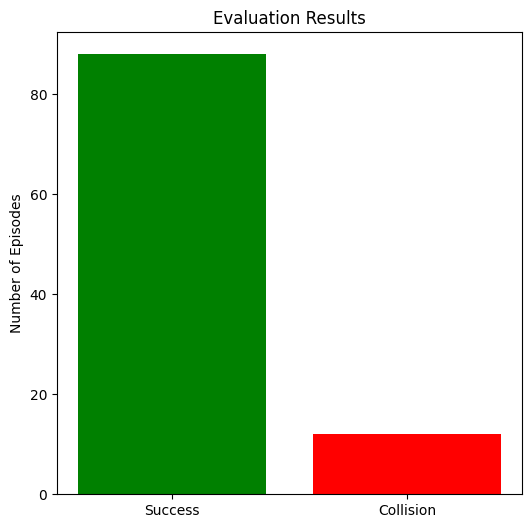

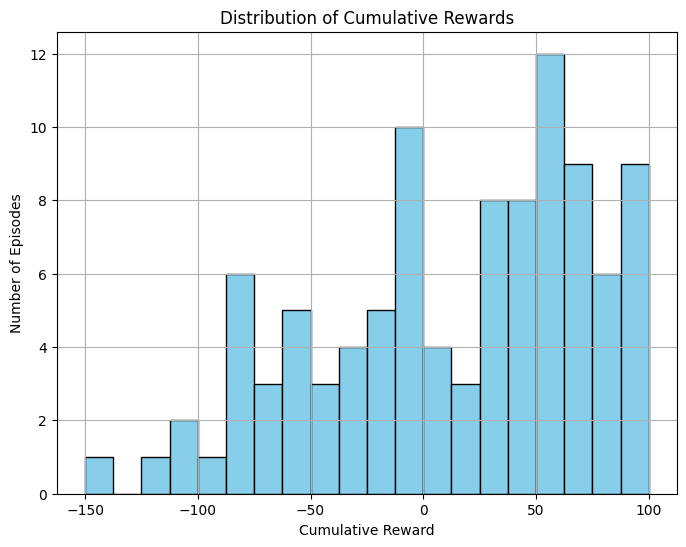

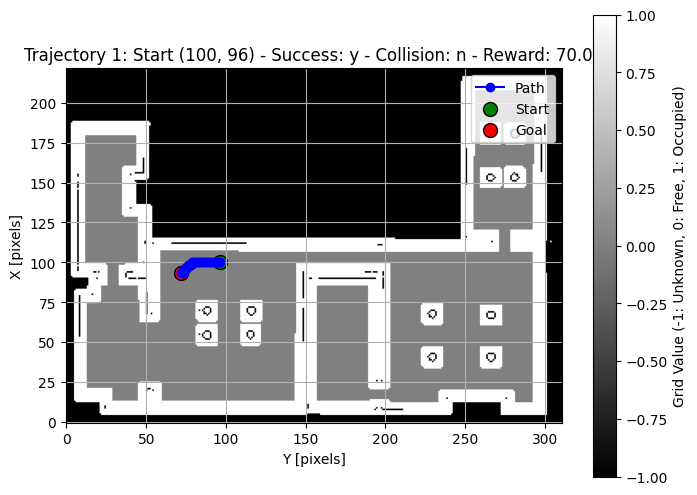

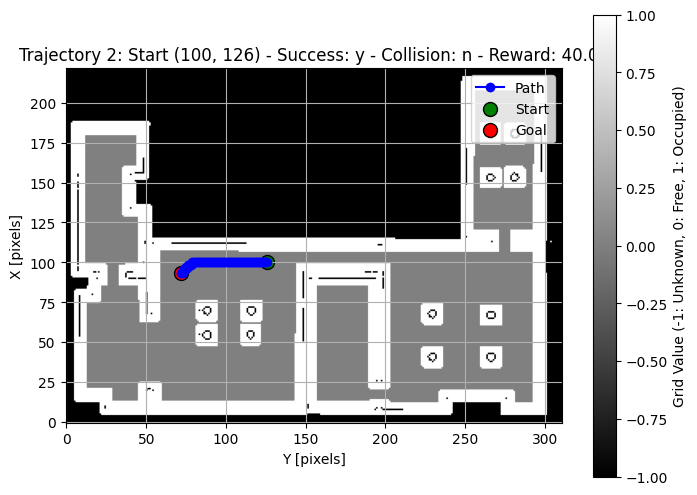

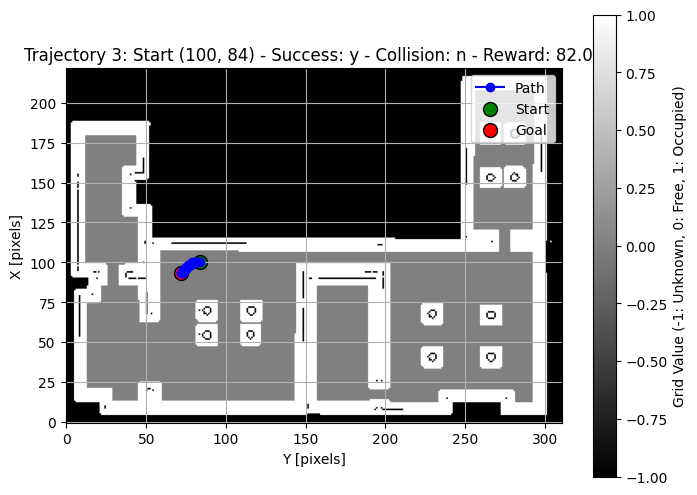

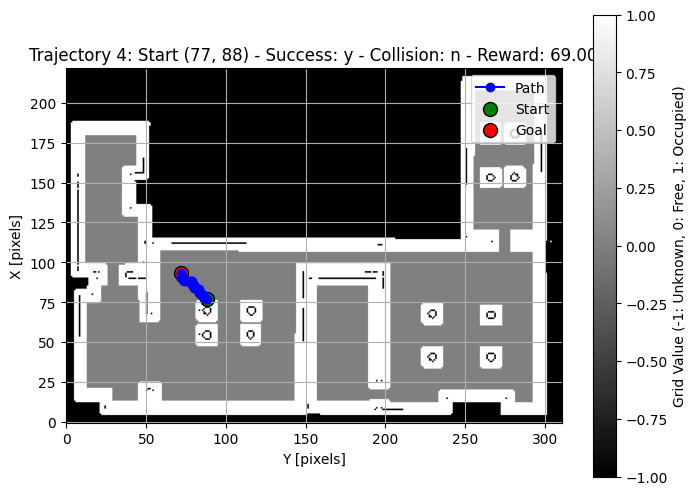

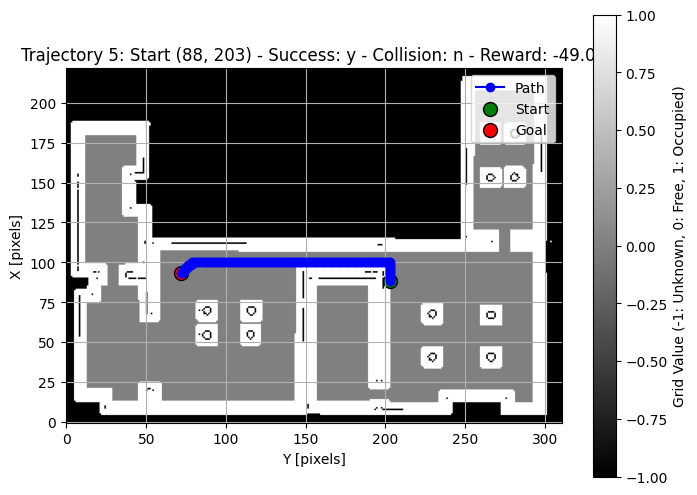

In [9]:
# -------------------------------
# Step 1: Import Libraries
# -------------------------------

import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import pandas as pd
from scipy.ndimage import binary_dilation
from tqdm import tqdm

# -------------------------------
# Step 2: Define the Policy Network
# -------------------------------

# Define the AWRPolicy (matching saved model structure)
class AWRPolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(AWRPolicy, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),  # Input layer
            nn.ReLU(),
            nn.Linear(256, 256),       # Hidden layer
            nn.ReLU(),
            nn.Linear(256, action_dim) # Output layer
        )

    def forward(self, state):
        return self.model(state)


# -------------------------------
# Step 3 Define the RL Dataset Class
# -------------------------------

class RLDataset(Dataset):
    def __init__(self, data):
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)
        self.rewards = torch.tensor([entry['r'] for entry in data], dtype=torch.float32)
        self.next_states = torch.tensor([entry["s'"] for entry in data], dtype=torch.float32)
        self.dones = torch.tensor([entry['d'] for entry in data], dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[idx]

# -------------------------------
# Step 4 Define Helper Functions
# -------------------------------

def process_map(image_path, occupied_threshold=50, free_threshold=240):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Map image not found at {image_path}.")
    map_image = Image.open(image_path).convert("L")
    map_array = np.array(map_image)
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)  # -1: Unknown
    occupancy_grid[map_array >= free_threshold] = 0           # 0: Free
    occupancy_grid[map_array <= occupied_threshold] = 1       # 1: Occupied
    print(f"Map processed: {occupancy_grid.shape[0]} rows, {occupancy_grid.shape[1]} columns.")
    return occupancy_grid

def inflate_obstacles(grid, inflation_radius_pixels):
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)
    occupied_mask = (grid == 1)
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)
    inflated_grid = np.copy(grid)
    inflated_grid[inflated_occupied & (grid == 0)] = 1  # Inflate free spaces to occupied
    print(f"Obstacles inflated by {inflation_radius_pixels} pixels.")
    return inflated_grid

def move_in_direction(state, action):
    directions = {
        0: (-1, 0),  # Up
        1: (1, 0),   # Down
        2: (0, -1),  # Left
        3: (0, 1)    # Right
    }
    if action not in directions:
        raise ValueError(f"Invalid action index: {action}")
    dx, dy = directions[action]
    return (state[0] + dx, state[1] + dy)

def compute_reward(current_state, next_state, goal, done):
    if next_state == goal:
        return 100
    else:
        return -1

def evaluate_single_trajectory(model, start_state, goal, grid, max_steps=1000, device="cpu"):
    model.eval()
    current_state = start_state
    path = [current_state]
    success = False
    collision = False
    cumulative_reward = 0.0

    for step in range(max_steps):
        state_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = model(state_tensor)
            action = torch.argmax(logits, dim=1).item()

        next_state = move_in_direction(current_state, action)
        next_state = (int(next_state[0]), int(next_state[1]))

        if not (0 <= next_state[0] < grid.shape[0] and 0 <= next_state[1] < grid.shape[1]):
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        if grid[next_state] == 1:
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        done = False
        if next_state == goal:
            success = True
            done = True
        reward = compute_reward(current_state, next_state, goal, done)
        cumulative_reward += reward

        path.append(next_state)
        current_state = next_state

        if done:
            break

    trajectory = {
        "Start": f"({start_state[0]}, {start_state[1]})",
        "Goal": f"({goal[0]}, {goal[1]})",
        "Path": path,
        "Success": "y" if success else "n",
        "Collision": "y" if collision else "n",
        "Reward Received": cumulative_reward
    }
    return trajectory

def visualize_path(grid, path, goal, title="Path Visualization"):
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray", origin="lower")
    plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")
    x_coords, y_coords = zip(*path)
    plt.plot(y_coords, x_coords, marker='o', color='blue', label="Path")
    plt.scatter(y_coords[0], x_coords[0], color='green', s=100, label="Start", edgecolors="black")
    plt.scatter(goal[1], goal[0], color='red', s=100, label="Goal", edgecolors="black")
    plt.title(title)
    plt.xlabel("Y [pixels]")
    plt.ylabel("X [pixels]")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Step 5: Load Dataset and Process Map
# -------------------------------

dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
model_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/final_awr_model.pth"
map_path = "/content/sim_classroom_map_enhanced.pgm"
csv_output_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/awr_policy_performance.csv"
goal = (93, 72)
inflation_radius_pixels = 5

print("Processing map...")
occupancy_grid = process_map(map_path)
inflated_grid = inflate_obstacles(occupancy_grid, inflation_radius_pixels)

print("Loading dataset...")
with open(dataset_path, "r") as f:
    rl_data = json.load(f)
print(f"Dataset loaded with {len(rl_data)} entries.")
full_dataset = RLDataset(rl_data)

state_dim = 2
action_dim = 4
awr_policy = AWRPolicy(state_dim, action_dim)

if not os.path.exists(model_path):
    raise FileNotFoundError(f"AWR policy model not found at {model_path}.")
awr_policy.load_state_dict(torch.load(model_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
awr_policy.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
awr_policy.eval()
print(f"AWR policy model loaded from {model_path}.")

num_samples = 100
if len(full_dataset) < num_samples:
    sampled_indices = list(range(len(full_dataset)))
else:
    sampled_indices = random.sample(range(len(full_dataset)), num_samples)

sampled_entries = [full_dataset[i] for i in sampled_indices]

trajectories = []
success_count = 0
collision_count = 0
total_cumulative_reward = 0.0

print("Evaluating AWR Policy on sampled start points...")
for idx, (state, action, reward, next_state, done) in enumerate(tqdm(sampled_entries, desc="Evaluating Trajectories")):
    start_state = tuple(state.numpy().astype(int))
    trajectory = evaluate_single_trajectory(
        model=awr_policy,
        start_state=start_state,
        goal=goal,
        grid=inflated_grid,
        max_steps=1000,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    if trajectory["Success"] == "y":
        success_count += 1
    if trajectory["Collision"] == "y":
        collision_count += 1
    total_cumulative_reward += trajectory["Reward Received"]
    trajectories.append({
        "Start": trajectory["Start"],
        "Goal": trajectory["Goal"],
        "Path": trajectory["Path"],
        "Success": trajectory["Success"],
        "Collision": trajectory["Collision"],
        "Reward Received": trajectory["Reward Received"]
    })

success_rate = (success_count / num_samples) * 100
collision_rate = (collision_count / num_samples) * 100
average_cumulative_reward = total_cumulative_reward / num_samples

print("\nEvaluation Metrics:")
print(f"Success Rate: {success_rate:.2f}% ({success_count}/{num_samples})")
print(f"Collision Rate: {collision_rate:.2f}% ({collision_count}/{num_samples})")
print(f"Average Cumulative Reward: {average_cumulative_reward:.2f}")

df_trajectories = pd.DataFrame(trajectories)
df_trajectories['Path'] = df_trajectories['Path'].apply(lambda x: str(x))
df_trajectories.to_csv(csv_output_path, index=False)
print(f"Trajectory data saved to {csv_output_path}.")

labels = ['Success', 'Collision']
counts = [success_count, collision_count]
plt.figure(figsize=(6, 6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title("Evaluation Results")
plt.ylabel("Number of Episodes")
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df_trajectories['Reward Received'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Cumulative Rewards")
plt.xlabel("Cumulative Reward")
plt.ylabel("Number of Episodes")
plt.grid(True)
plt.show()

for i in range(min(5, len(df_trajectories))):
    traj = df_trajectories.iloc[i]
    path = eval(traj['Path'])
    visualize_path(
        grid=inflated_grid,
        path=path,
        goal=goal,
        title=f"Trajectory {i+1}: Start {traj['Start']} - Success: {traj['Success']} - Collision: {traj['Collision']} - Reward: {traj['Reward Received']:.2f}"
    )


## BCQL Training

In [19]:
# -------------------------------
# Step 1: Import Libraries
# -------------------------------
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F  # Added import for functional
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# -------------------------------
# Step 2: Define the RL Dataset Class
# -------------------------------

class RLDataset(Dataset):
    def __init__(self, data):
        self.states = torch.tensor([entry['s'] for entry in data], dtype=torch.float32)
        self.actions = torch.tensor([entry['a'] for entry in data], dtype=torch.long)
        self.rewards = torch.tensor([entry['r'] for entry in data], dtype=torch.float32)
        self.next_states = torch.tensor([entry["s'"] for entry in data], dtype=torch.float32)
        self.dones = torch.tensor([entry['d'] for entry in data], dtype=torch.float32)

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx], self.rewards[idx], self.next_states[idx], self.dones[idx]

# -------------------------------
# Step 3: Define the BCQ Components
# -------------------------------
# VAE Definition
class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim=32):
        super(VAE, self).__init__()
        self.action_dim = action_dim  # Store action_dim for one-hot encoding
        input_dim = state_dim + action_dim  # Input size is the sum of state and action dimensions
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim),  # Mean and log_std
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, state, action):
        # Ensure actions are one-hot encoded if necessary
        if action.dim() == 1:
            action = F.one_hot(action, num_classes=self.action_dim).float()
        elif action.dim() == 2 and action.size(1) != self.action_dim:
            action = F.one_hot(torch.argmax(action, dim=1), num_classes=self.action_dim).float()

        x = torch.cat([state, action], dim=-1)  # Concatenate state and action
        latent_params = self.encoder(x)
        mean, log_std = latent_params.chunk(2, dim=-1)
        std = torch.exp(log_std)

        # Reparameterization trick
        z = mean + std * torch.randn_like(std)

        # Decode
        recon_action = self.decoder(torch.cat([z, state], dim=-1))
        return mean, std, recon_action

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.action_dim = action_dim  # Store action_dim for one-hot encoding
        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        # Ensure actions are one-hot encoded
        if action.dim() == 1:
            action = F.one_hot(action, num_classes=self.action_dim).float()
        elif action.dim() == 2 and action.size(1) != self.action_dim:
            action = F.one_hot(torch.argmax(action, dim=1), num_classes=self.action_dim).float()

        return self.model(torch.cat([state, action], dim=-1))

class Perturbation(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Perturbation, self).__init__()
        self.action_dim = action_dim  # Store action_dim for one-hot encoding
        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )

    def forward(self, state, action):
        # Ensure actions are one-hot encoded
        if action.dim() == 1:
            action = F.one_hot(action, num_classes=self.action_dim).float()
        elif action.dim() == 2 and action.size(1) != self.action_dim:
            action = F.one_hot(torch.argmax(action, dim=1), num_classes=self.action_dim).float()

        return action + 0.05 * self.model(torch.cat([state, action], dim=-1))

# -------------------------------
# Step 4: Training the BCQ Components
# -------------------------------

def train_vae(vae, dataset, vae_lr=0.001, latent_dim=32, batch_size=256, epochs=50, device="cpu"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(vae.parameters(), lr=vae_lr)
    vae.train()
    for epoch in range(epochs):
        total_loss = 0
        for states, actions, _, _, _ in dataloader:
            states, actions = states.to(device), actions.to(device)

            # Forward pass
            mean, std, recon_actions = vae(states, actions)
            actions_one_hot = F.one_hot(actions, num_classes=vae.action_dim).float()
            recon_loss = F.mse_loss(recon_actions, actions_one_hot)
            kl_loss = -0.5 * torch.mean(1 + 2 * torch.log(std) - mean**2 - std**2)
            loss = recon_loss + kl_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"VAE Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

def train_q_network(q1, q2, vae, dataset, q_lr=0.001, gamma=0.99, batch_size=256, epochs=50, device="cpu"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer_q1 = torch.optim.Adam(q1.parameters(), lr=q_lr)
    optimizer_q2 = torch.optim.Adam(q2.parameters(), lr=q_lr)
    q1.train()
    q2.train()
    vae.eval()
    for epoch in range(epochs):
        total_loss = 0
        for states, actions, rewards, next_states, dones in dataloader:
            states, actions, rewards, next_states, dones = (
                states.to(device),
                actions.to(device),
                rewards.to(device),
                next_states.to(device),
                dones.to(device),
            )

            with torch.no_grad():
                # One-hot encode actions
                actions_one_hot = F.one_hot(actions, num_classes=vae.action_dim).float()
                # Encode next states and actions to get latent variables
                latent_params = vae.encoder(torch.cat([next_states, actions_one_hot], dim=-1))
                mean, std = latent_params.chunk(2, dim=-1)
                z = mean  # Using mean for simplicity; could also sample
                # Decode to get next actions
                next_action = vae.decoder(torch.cat([z, next_states], dim=-1))
                # Ensure next_action is properly scaled if necessary
                # Compute Q-values for next actions
                q1_target = q1(next_states, next_action)
                q2_target = q2(next_states, next_action)
                min_q_target = torch.min(q1_target, q2_target).squeeze(-1)
                target = rewards + gamma * (1 - dones) * min_q_target

            # Current Q estimates
            current_q1 = q1(states, actions_one_hot).squeeze(-1)
            current_q2 = q2(states, actions_one_hot).squeeze(-1)

            # Compute losses
            q1_loss = F.mse_loss(current_q1, target)
            q2_loss = F.mse_loss(current_q2, target)

            # Optimize Q1
            optimizer_q1.zero_grad()
            q1_loss.backward()
            optimizer_q1.step()

            # Optimize Q2
            optimizer_q2.zero_grad()
            q2_loss.backward()
            optimizer_q2.step()

            total_loss += (q1_loss.item() + q2_loss.item())
        avg_loss = total_loss / len(dataloader)
        print(f"Q-Network Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

def train_perturbation(pert, vae, dataset, pert_lr=0.001, batch_size=256, epochs=50, device="cpu"):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(pert.parameters(), lr=pert_lr)
    pert.train()
    vae.eval()
    for epoch in range(epochs):
        total_loss = 0
        for states, actions, _, _, _ in dataloader:
            states, actions = states.to(device), actions.to(device)

            with torch.no_grad():
                # One-hot encode actions
                actions_one_hot = F.one_hot(actions, num_classes=vae.action_dim).float()
                # Encode states and actions to get latent variables
                latent_params = vae.encoder(torch.cat([states, actions_one_hot], dim=-1))
                mean, std = latent_params.chunk(2, dim=-1)
                z = mean  # Using mean for simplicity; could also sample
                # Decode to get reconstructed actions
                recon_action = vae.decoder(torch.cat([z, states], dim=-1))
                # Optionally, apply softmax if actions are discrete
                recon_action = F.softmax(recon_action, dim=-1)

            # Perturb actions
            perturbed_action = pert(states, recon_action)
            # Optionally, apply softmax or another activation to perturbed_action
            perturbed_action = F.softmax(perturbed_action, dim=-1)

            # Compute loss against one-hot encoded actions
            pert_loss = F.mse_loss(perturbed_action, actions_one_hot)

            optimizer.zero_grad()
            pert_loss.backward()
            optimizer.step()
            total_loss += pert_loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Perturbation Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# -------------------------------
# Step 5: Main Script
# -------------------------------

if __name__ == "__main__":
    # Define dataset path
    dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}.")

    # Load dataset
    with open(dataset_path, "r") as f:
        rl_data = json.load(f)
    dataset = RLDataset(rl_data)

    # Model Parameters
    state_dim = 2
    action_dim = 4
    latent_dim = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize Models
    vae = VAE(state_dim, action_dim, latent_dim).to(device)
    q1 = QNetwork(state_dim, action_dim).to(device)
    q2 = QNetwork(state_dim, action_dim).to(device)
    pert = Perturbation(state_dim, action_dim).to(device)

    # Print model summaries (optional)
    # print(vae)
    # print(q1)
    # print(q2)
    # print(pert)

    # Train Models
    print("Starting VAE training...")
    train_vae(vae, dataset, vae_lr=0.001, latent_dim=latent_dim, epochs=50, device=device)

    print("\nStarting Q-Network training...")
    train_q_network(q1, q2, vae, dataset, gamma=0.99, epochs=50, device=device)

    print("\nStarting Perturbation training...")
    train_perturbation(pert, vae, dataset, epochs=50, device=device)

    # Save Models
    save_dir = "./trained_models"
    os.makedirs(save_dir, exist_ok=True)
    torch.save(vae.state_dict(), os.path.join(save_dir, "vae.pth"))
    torch.save(q1.state_dict(), os.path.join(save_dir, "q1.pth"))
    torch.save(q2.state_dict(), os.path.join(save_dir, "q2.pth"))
    torch.save(pert.state_dict(), os.path.join(save_dir, "pert.pth"))
    print("\nModels saved successfully in the 'trained_models' directory!")


Using device: cuda
Starting VAE training...
VAE Epoch 1/50, Loss: 30138293526558.9492
VAE Epoch 2/50, Loss: 8.8485
VAE Epoch 3/50, Loss: 1.0215
VAE Epoch 4/50, Loss: 0.1804
VAE Epoch 5/50, Loss: 0.0985
VAE Epoch 6/50, Loss: 0.0795
VAE Epoch 7/50, Loss: 0.0670
VAE Epoch 8/50, Loss: 0.0603
VAE Epoch 9/50, Loss: 0.0559
VAE Epoch 10/50, Loss: 0.0531
VAE Epoch 11/50, Loss: 0.0511
VAE Epoch 12/50, Loss: 0.0487
VAE Epoch 13/50, Loss: 0.0468
VAE Epoch 14/50, Loss: 0.0449
VAE Epoch 15/50, Loss: 0.0402
VAE Epoch 16/50, Loss: 0.0378
VAE Epoch 17/50, Loss: 0.0361
VAE Epoch 18/50, Loss: 0.0350
VAE Epoch 19/50, Loss: 0.0341
VAE Epoch 20/50, Loss: 0.0334
VAE Epoch 21/50, Loss: 0.0327
VAE Epoch 22/50, Loss: 0.0322
VAE Epoch 23/50, Loss: 0.0318
VAE Epoch 24/50, Loss: 0.0313
VAE Epoch 25/50, Loss: 0.0309
VAE Epoch 26/50, Loss: 0.0305
VAE Epoch 27/50, Loss: 0.0301
VAE Epoch 28/50, Loss: 0.0299
VAE Epoch 29/50, Loss: 0.0297
VAE Epoch 30/50, Loss: 0.0296
VAE Epoch 31/50, Loss: 0.0294
VAE Epoch 32/50, Loss:

##BCQL Evaluation

<ipython-input-41-ea81c2374e64>:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(vae_path))
<ipython-input-41-ea81c2374e64>:189: FutureWarni

Success Rate: 52.00%
Collision Rate: 48.00%
Average Cumulative Reward: -6.41
Results saved to /content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/bcq_policy_results.csv


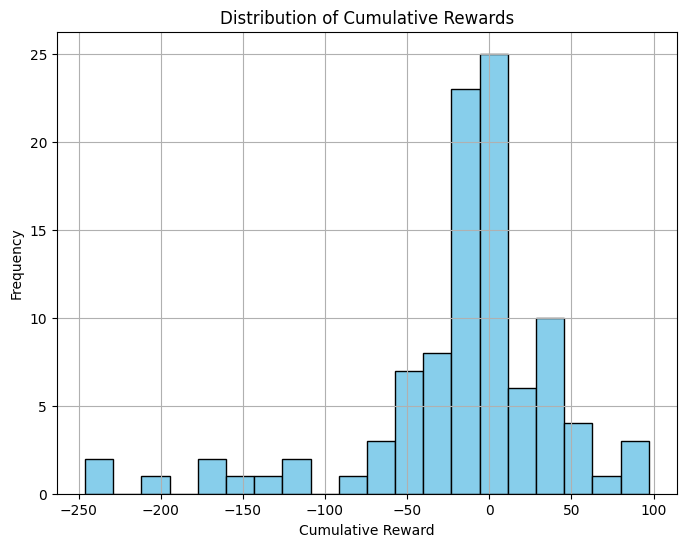

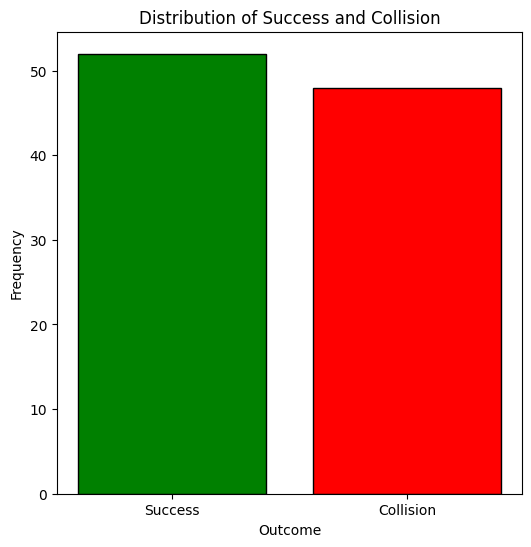

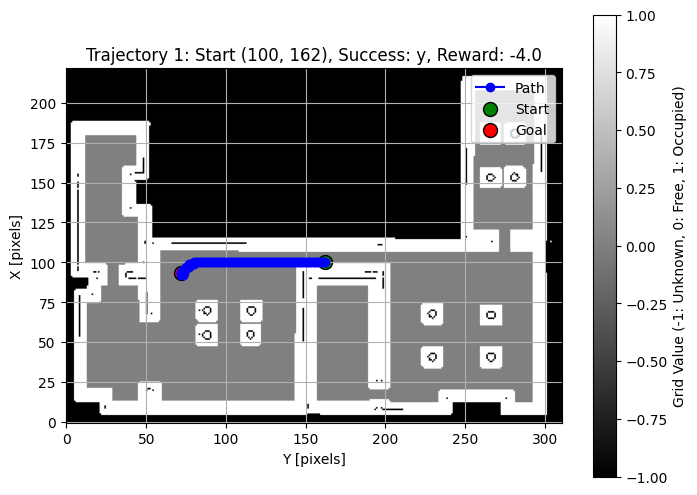

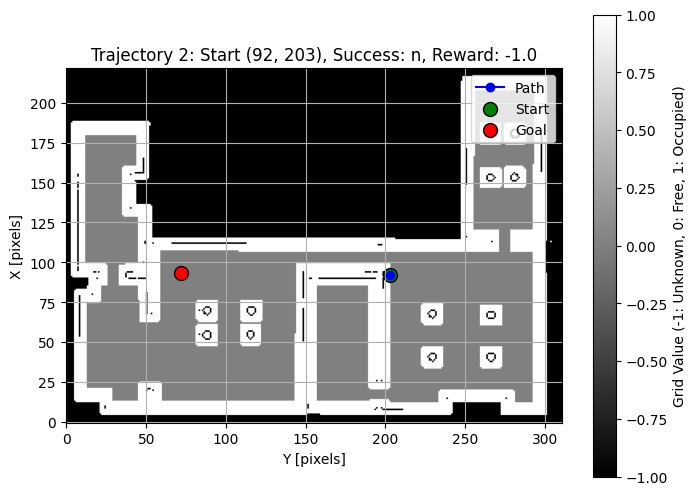

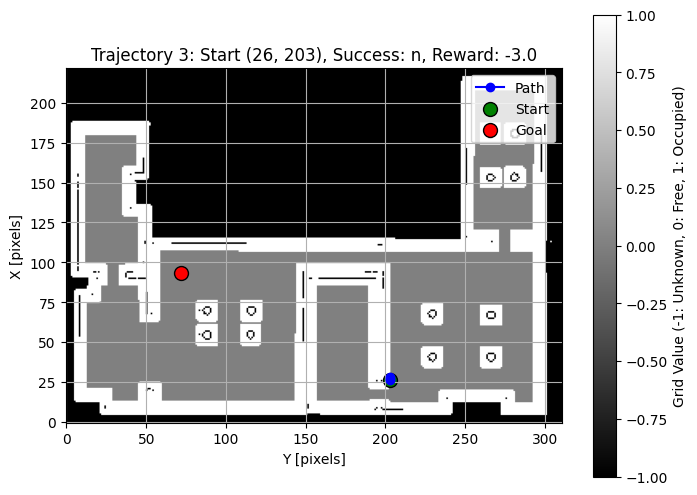

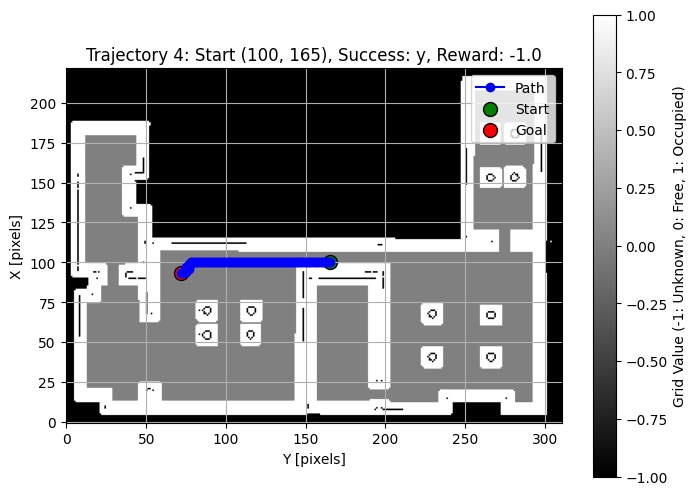

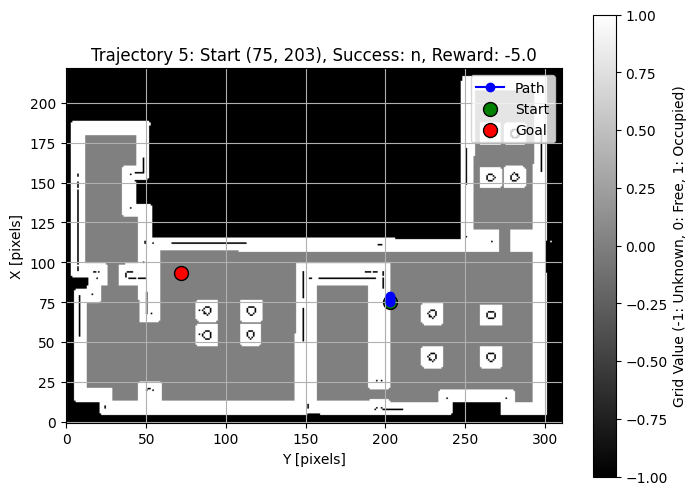

In [41]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from scipy.ndimage import binary_dilation
import random
import pandas as pd

# -------------------------------
# Step 1: Define the Model Classes
# -------------------------------

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        return self.model(torch.cat([state, action], dim=-1))

class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim=32):
        super(VAE, self).__init__()
        input_dim = state_dim + action_dim
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim)  # Mean and log_std
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        latent_params = self.encoder(x)
        mean, log_std = latent_params.chunk(2, dim=-1)
        std = torch.exp(log_std)
        z = mean + std * torch.randn_like(std)
        recon_action = self.decoder(torch.cat([z, state], dim=-1))
        return mean, std, recon_action

# -------------------------------
# Step 2: Helper Functions
# -------------------------------

def process_map(image_path, occupied_threshold=50, free_threshold=240):
    map_image = Image.open(image_path).convert("L")
    map_array = np.array(map_image)
    occupancy_grid = -np.ones_like(map_array, dtype=np.int8)
    occupancy_grid[map_array >= free_threshold] = 0
    occupancy_grid[map_array <= occupied_threshold] = 1
    return occupancy_grid

def inflate_obstacles(grid, inflation_radius_pixels):
    struct = np.ones((2 * inflation_radius_pixels + 1, 2 * inflation_radius_pixels + 1), dtype=bool)
    occupied_mask = (grid == 1)
    inflated_occupied = binary_dilation(occupied_mask, structure=struct)
    inflated_grid = np.copy(grid)
    inflated_grid[inflated_occupied & (grid == 0)] = 1
    return inflated_grid

def move_in_direction(state, action):
    directions = {
        0: (-1, 0),  # Up
        1: (1, 0),   # Down
        2: (0, -1),  # Left
        3: (0, 1)    # Right
    }
    dx, dy = directions[action]
    return (state[0] + dx, state[1] + dy)

def compute_reward(current_state, next_state, goal, done):
    return 100 if next_state == goal else -1

def sample_action(vae, state, device):
    with torch.no_grad():
        z = torch.randn((1, 32), device=device)
        action = vae.decoder(torch.cat([z, state], dim=-1))
    return torch.argmax(action, dim=-1).item()

def evaluate_single_trajectory(q_network, vae, start_state, goal, grid, max_steps=1000, device="cpu"):
    q_network.eval()
    vae.eval()
    current_state = start_state
    path = [current_state]
    success = False
    collision = False
    cumulative_reward = 0.0

    for step in range(max_steps):
        state_tensor = torch.tensor(current_state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            action_index = sample_action(vae, state_tensor, device)

        next_state = move_in_direction(current_state, action_index)
        next_state = (int(next_state[0]), int(next_state[1]))

        if not (0 <= next_state[0] < grid.shape[0] and 0 <= next_state[1] < grid.shape[1]):
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        if grid[next_state] == 1:
            collision = True
            cumulative_reward += compute_reward(current_state, next_state, goal, done=True)
            break

        done = False
        if next_state == goal:
            success = True
            done = True
        reward = compute_reward(current_state, next_state, goal, done)
        cumulative_reward += reward

        path.append(next_state)
        current_state = next_state

        if done:
            break

    trajectory = {
        "Start": f"({start_state[0]}, {start_state[1]})",
        "Goal": f"({goal[0]}, {goal[1]})",
        "Path": path,
        "Success": "y" if success else "n",
        "Collision": "y" if collision else "n",
        "Reward Received": cumulative_reward
    }
    return trajectory

def visualize_path(grid, path, goal, title="Path Visualization"):
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap="gray", origin="lower")
    plt.colorbar(label="Grid Value (-1: Unknown, 0: Free, 1: Occupied)")
    x_coords, y_coords = zip(*path)
    plt.plot(y_coords, x_coords, marker='o', color='blue', label="Path")
    plt.scatter(y_coords[0], x_coords[0], color='green', s=100, label="Start", edgecolors="black")
    plt.scatter(goal[1], goal[0], color='red', s=100, label="Goal", edgecolors="black")
    plt.title(title)
    plt.xlabel("Y [pixels]")
    plt.ylabel("X [pixels]")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Step 3: Main Evaluation Script
# -------------------------------

# Paths
dataset_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/rl_dataset3_discrete.json"
vae_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/models/vae.pth"
q1_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/models/q1.pth"
map_path = "/content/sim_classroom_map_enhanced.pgm"
goal = (93, 72)
inflation_radius_pixels = 5
num_samples = 100

# Load data and map
with open(dataset_path, "r") as f:
    rl_data = json.load(f)
occupancy_grid = process_map(map_path)
inflated_grid = inflate_obstacles(occupancy_grid, inflation_radius_pixels)

# Load models
state_dim = 2
action_dim = 4
vae = VAE(state_dim, action_dim).to("cuda" if torch.cuda.is_available() else "cpu")
vae.load_state_dict(torch.load(vae_path))
vae.eval()

q1 = QNetwork(state_dim, action_dim).to("cuda" if torch.cuda.is_available() else "cpu")
q1.load_state_dict(torch.load(q1_path))
q1.eval()

# Evaluate trajectories
sampled_indices = random.sample(range(len(rl_data)), num_samples)
trajectories = []
success_count = 0
collision_count = 0
total_cumulative_reward = 0.0

for i in tqdm(sampled_indices, desc="Evaluating Trajectories"):
    start_state = tuple(rl_data[i]['s'])
    trajectory = evaluate_single_trajectory(
        q_network=q1,
        vae=vae,
        start_state=start_state,
        goal=goal,
        grid=inflated_grid,
        max_steps=1000,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    trajectories.append(trajectory)
    if trajectory["Success"] == "y":
        success_count += 1
    if trajectory["Collision"] == "y":
        collision_count += 1
    total_cumulative_reward += trajectory["Reward Received"]

# Compute metrics
success_rate = (success_count / num_samples) * 100
collision_rate = (collision_count / num_samples) * 100
average_cumulative_reward = total_cumulative_reward / num_samples
print(f"Success Rate: {success_rate:.2f}%")
print(f"Collision Rate: {collision_rate:.2f}%")
print(f"Average Cumulative Reward: {average_cumulative_reward:.2f}")

# Save results to CSV
output_path = "/content/drive/My Drive/Colab Notebooks/ECE595/GazeboMap/bcq_policy_results.csv"
pd.DataFrame(trajectories).to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Plot histogram of cumulative rewards
plt.figure(figsize=(8, 6))
plt.hist(rewards, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Cumulative Rewards")
plt.xlabel("Cumulative Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Success and collision counts
outcomes = ['Success', 'Collision']
counts = [success_count, collision_count]

# Plot histogram for success and collision
plt.figure(figsize=(6, 6))
plt.bar(outcomes, counts, color=['green', 'red'], edgecolor='black')
plt.title("Distribution of Success and Collision")
plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.show()


# Visualize 5 random trajectories
for i in range(min(5, len(trajectories))):
    traj = trajectories[i]
    visualize_path(
        grid=inflated_grid,
        path=traj["Path"],
        goal=goal,
        title=f"Trajectory {i+1}: Start {traj['Start']}, Success: {traj['Success']}, Reward: {traj['Reward Received']}"
    )
